--
title: Multi-level modeling with binomial GLM with baseball on-base percentage
mathjax: True
--

A few months ago, I professed my interest in learning multi-level models. It took me through a journey where I dove into Bayesian inference. I recently learned multi-level models (also known as heirarchical models) and the concepts of shrinkage and partial pooling were really interesting to me. Multi-level models are interesting in how they handle grouping variables to make more accurate estimates, especially groups of unequal size.

Let's illustrate this with baseball data. Specifically, we want to estimate on-base percentage of opposing batters, when facing the Padres starting pitchers in the month of August 2021. Getting "on base" is a binary event and therefore we will use a binomial generalized linear model.

(contrived example)

(borrow from statistical rethinking)

I'm purposefully picking this time frame because the Padres made a change to their pitching coach on August 23. We can see the effect of different sample sizes for the starting pitchers while using both the pitchers and the pitching coaches as grouping variables. I'm hiding the data pulling process for simplicity, but I used the pybaseball package. I'll focus on the modeling component using pymc3.

Let's take a look at the results when analyzed with fixed and multi-level (AKA mixed effects) models!

In [11]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
from scipy.special import expit
from scipy.special import expit as logistic
from scipy.special import logit

<IPython.core.display.Javascript object>

In [12]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz
sns.set_context("talk")

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


<IPython.core.display.Javascript object>

In [13]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

In [259]:
DATA_DIR = "other_data/"
df_padres = pd.read_csv(
    DATA_DIR + "df_padres_pitching_summary_August2021.csv", index_col=0
).drop("index", axis=1)
print("Shape of df: ", df_padres.shape)

Shape of df:  (27, 6)


<IPython.core.display.Javascript object>

In [260]:
# Look at the sample size differences
(
    df_padres
    .groupby("pitcher")
    .sum("n_ab")
    .sort_values(by='n_ab')
)


,n_ab,n_ob,obp
pitcher,,,
"('johnson', 'pierce')",5,2,0.400000
"('strahm', 'matt')",8,4,0.500000
"('knehr', 'reiss')",10,2,0.200000
"('paddack', 'chris')",17,3,0.176471
"('stammen', 'craig')",27,11,1.170455
"('arrieta', 'jake')",36,18,1.003096
"('darvish', 'yu')",64,17,0.876667
"('weathers', 'ryan')",67,28,1.658730
"('musgrove', 'joe')",129,36,1.427917


<IPython.core.display.Javascript object>

In [24]:
print("No. of starting pitchers: ", len(df_padres["pitcher"].unique()))

No. of starting pitchers:  10


<IPython.core.display.Javascript object>

The dataframe has 27 dates, representing the game days for the month of August. The Padres used 10 starting pitchers, which is typically higher than most teams, reflecting the team's dire injury situation. But this variability in sample size will illustrate the effect of the mixed model.

Down below I show the first five games of the month, then the last 10 games of the month to illustrate the pitching coach change.

In [28]:
# First five games of August
df_padres.head()

,pitcher,game_date,n_ab,n_ob,obp,pitching_coach
0,"('knehr', 'reiss')",2021-08-01,10,2,0.200000,Rothschild
1,"('snell', 'blake')",2021-08-03,23,9,0.391304,Rothschild
2,"('musgrove', 'joe')",2021-08-04,24,7,0.291667,Rothschild
3,"('arrieta', 'jake')",2021-08-05,19,9,0.473684,Rothschild
4,"('weathers', 'ryan')",2021-08-06,16,8,0.500000,Rothschild


<IPython.core.display.Javascript object>

In [29]:
# Last ten games of August
df_padres.tail(10)

,pitcher,game_date,n_ab,n_ob,obp,pitching_coach
17,"('snell', 'blake')",2021-08-20,19,4,0.210526,Rothschild
18,"('musgrove', 'joe')",2021-08-21,24,6,0.250000,Rothschild
19,"('stammen', 'craig')",2021-08-22,8,3,0.375000,Rothschild
20,"('johnson', 'pierce')",2021-08-24,5,2,0.400000,Fritz
21,"('snell', 'blake')",2021-08-25,26,3,0.115385,Fritz
22,"('darvish', 'yu')",2021-08-26,24,6,0.250000,Fritz
23,"('musgrove', 'joe')",2021-08-27,32,5,0.156250,Fritz
24,"('weathers', 'ryan')",2021-08-28,12,4,0.333333,Fritz
25,"('paddack', 'chris')",2021-08-30,17,3,0.176471,Fritz
26,"('snell', 'blake')",2021-08-31,23,2,0.086957,Fritz


<IPython.core.display.Javascript object>

In [127]:
# Look at the sample size differences
(
    df_padres
    .groupby("pitching_coach")
    .sum("n_ab")
    .sort_values(by='n_ab')
)['n_ab']


pitching_coach
Fritz         139
Rothschild    363
Name: n_ab, dtype: int64

<IPython.core.display.Javascript object>

# Preparing the dataframe

Now for the modeling. I purposefully simplified this scenario so that we can use a binomial GLM. We'll build one fixed effect model with normal, regularizing priors that does not use grouping. We'll then build a multi-level model under the pitching_coach variable.

First we'll have to encode our categorical variables of `pitcher` and `pitching_coach`. We'll ignore game_date for now.

In [30]:
df_padres["pitcher_code"] = pd.Categorical(df_padres["pitcher"]).codes

# Look at pitcher code assignment
df_pitcher_code = (
    df_padres[["pitcher", "pitcher_code"]]
    .drop_duplicates()
    .sort_values(by="pitcher_code")
    .reset_index(drop=True)
    .copy()
)

df_pitcher_code

,pitcher,pitcher_code
0,"('arrieta', 'jake')",0
1,"('darvish', 'yu')",1
2,"('johnson', 'pierce')",2
3,"('knehr', 'reiss')",3
4,"('musgrove', 'joe')",4
5,"('paddack', 'chris')",5
6,"('snell', 'blake')",6
7,"('stammen', 'craig')",7
8,"('strahm', 'matt')",8
9,"('weathers', 'ryan')",9


<IPython.core.display.Javascript object>

In [35]:
df_padres["coach_code"] = pd.Categorical(
    df_padres["pitching_coach"], categories=["Rothschild", "Fritz"]
).codes

# Look at pitching_coach code assignment
df_coach_code = (
    df_padres[["pitching_coach", "coach_code"]]
    .drop_duplicates()
    .sort_values(by="coach_code")
    .reset_index(drop=True)
    .copy()
)
df_coach_code

,pitching_coach,coach_code
0,Rothschild,0
1,Fritz,1


<IPython.core.display.Javascript object>

Here's what the dataframe looks like now (first five and last 5 rows).

In [40]:
pd.concat([df_padres.head(), df_padres.tail()], axis=0)

,pitcher,game_date,n_ab,n_ob,obp,pitching_coach,pitcher_code,pitching_coach_code,coach_code
0,"('knehr', 'reiss')",2021-08-01,10,2,0.200000,Rothschild,3,0,0
1,"('snell', 'blake')",2021-08-03,23,9,0.391304,Rothschild,6,0,0
2,"('musgrove', 'joe')",2021-08-04,24,7,0.291667,Rothschild,4,0,0
3,"('arrieta', 'jake')",2021-08-05,19,9,0.473684,Rothschild,0,0,0
4,"('weathers', 'ryan')",2021-08-06,16,8,0.500000,Rothschild,9,0,0
22,"('darvish', 'yu')",2021-08-26,24,6,0.250000,Fritz,1,1,1
23,"('musgrove', 'joe')",2021-08-27,32,5,0.156250,Fritz,4,1,1
24,"('weathers', 'ryan')",2021-08-28,12,4,0.333333,Fritz,9,1,1
25,"('paddack', 'chris')",2021-08-30,17,3,0.176471,Fritz,5,1,1
26,"('snell', 'blake')",2021-08-31,23,2,0.086957,Fritz,6,1,1


<IPython.core.display.Javascript object>

We can also create variables for the number of different pitchers and coaches for use in our model.

In [34]:
n_pitcher = len(df_padres["pitcher"].unique())
n_coach = len(df_padres["pitching_coach"].unique())

print("No. of different pitchers: ", n_pitcher)
print("No. of different coaches: ", n_coach)

No. of different pitchers:  10
No. of different coaches:  2


<IPython.core.display.Javascript object>

# `Pitcher` only models

## Fixed effects

**Model `m1` equation**

$$O_i \sim \text{Binomial}(n_i, p_i) \tag{O for number of on-base events}$$

$$\text{logit}(p_i) = \alpha_{\text{PITCHER}[i]} \tag{pitcher is encoded as an index variable}$$

$$\alpha_j \sim \text{Normal}(0, 2) \tag{regularizing prior for each pitcher}$$

In [189]:
# modified from repo
with pm.Model() as m1:
    # regularizing prior is pretty wide
    a = pm.Normal("a", 0, 2, shape=n_pitcher)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample
    trace_m1 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


<IPython.core.display.Javascript object>

Text(0.5, 0, 'log-odds\n(on-base event)')

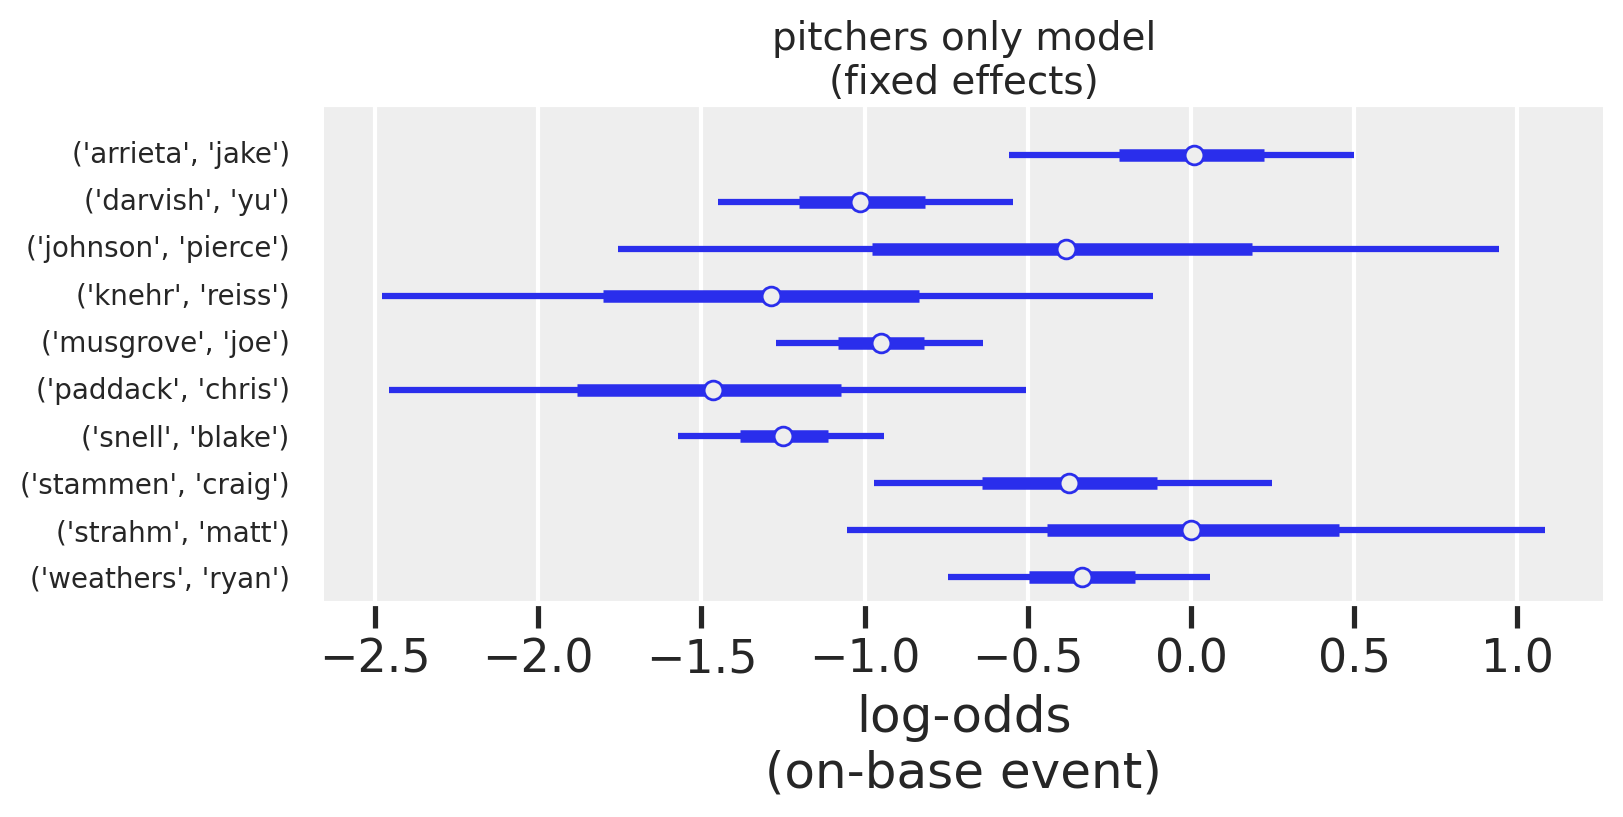

<IPython.core.display.Javascript object>

In [201]:
f, ax1 = plt.subplots(figsize=(8, 4))
az.plot_forest(trace_m1, combined=True, ax=ax1)

ax1.set_title("pitchers only model\n(fixed effects)", size=14)
# ax1.set_yticks(range(n_pitcher))  # labels not lining up
ax1.set_yticks(np.linspace(0, 7.5, n_pitcher))
ax1.set_yticklabels(sorted(df_padres["pitcher"].unique())[::-1], fontsize=10)
ax1.set_xlabel("log-odds\n(on-base event)")

## Mixed effects

### Centered paramaterization

**Model `m2` equation**

$$O_i \sim \text{Binomial}(n_i, p_i) \tag{O for number of on-base events}$$

$$\text{logit}(p_i) = \alpha_{\text{PITCHER}[i]} \tag{pitcher is encoded as an index variable}$$

$$\alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior}$$

$$\bar{\alpha} \sim \text{Normal}(0, 1) \tag{prior for average pitcher}$$

$$ \sigma \sim \text{Half-Normal}(0, 1) \tag{prior for standard deviation of pitchers} $$

In [245]:
with pm.Model() as m2:

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 1)

    # prior for standard deviation of pitchers
    sigma = pm.HalfNormal("sigma", sigma=1)

    # addaptive prior learns across pitchers
    a = pm.Normal("a", a_bar, sigma, shape=n_pitcher)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample - increased tune, target_accept
    trace_m2 = pm.sample(
        draws=1000,
        random_seed=19,
        tune=2000,
        target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
INFO:pymc3:NUTS: [a, sigma, a_bar]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 18 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 18 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
IN

<IPython.core.display.Javascript object>

Text(0.5, 0, 'log-odds\n(on-base event)')

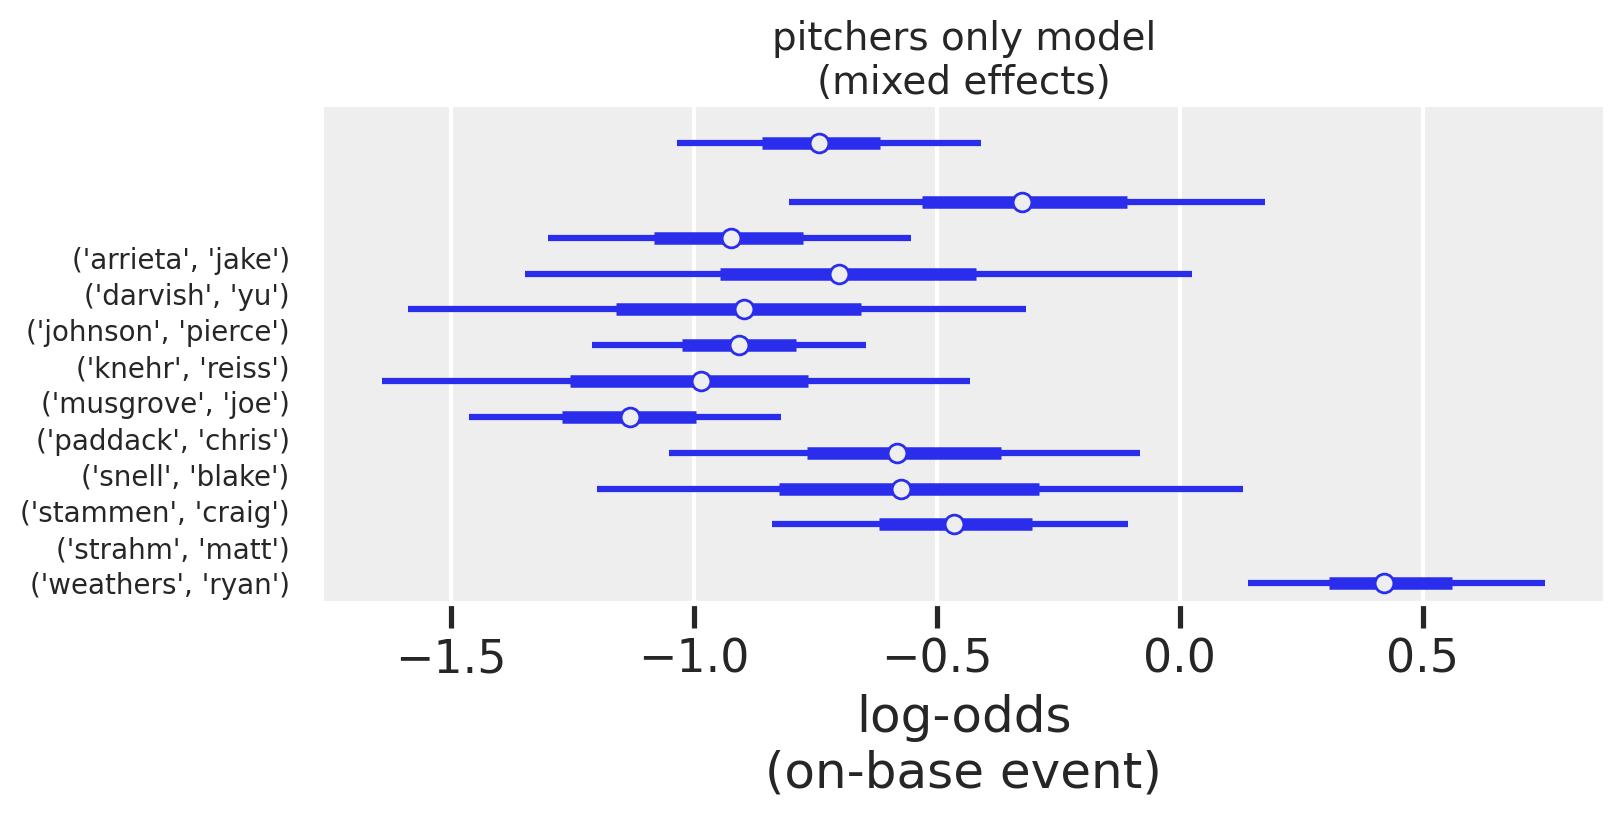

<IPython.core.display.Javascript object>

In [246]:
f, ax1 = plt.subplots(figsize=(8, 4))
az.plot_forest(trace_m2, combined=True, ax=ax1)

ax1.set_title("pitchers only model\n(mixed effects)", size=14)
ax1.set_yticks(np.linspace(0, 7.5, n_pitcher))
ax1.set_yticklabels(sorted(df_padres["pitcher"].unique())[::-1], fontsize=10)
ax1.set_xlabel("log-odds\n(on-base event)")

### Non-centered paramaterization

**Model `m3` equation**

$$O_i \sim \text{Binomial}(n_i, p_i) \tag{O for number of on-base events}$$

$$\text{logit}(p_i) = \alpha_{\text{PITCHER}[i]} \tag{centered paramaterization for comparison}$$

$$\text{logit}(p_i) = \bar{\alpha} + z_{\text{PITCHER}[i]}\sigma_{\alpha} \tag{non-centered parameterization}$$

$$z_j \sim \text{Normal}(0, 1) \tag{standardized intercepts for pitcher}$$

$$\bar{\alpha} \sim \text{Normal}(0, 1.5) \tag{prior for average pitcher}$$

$$\sigma_{\alpha} \sim \text{HalfNormal}(0,1) \tag{prior for SD of pitchers}$$

In [242]:
# Looked at repo code for R 13.29
with pm.Model() as m3:

    sigma_a = pm.HalfNormal("sigma_a", sigma=1)
    a_bar = pm.Normal("a_bar", 0, 1)
    z = pm.Normal("z", 0, 1, shape=n_pitcher)

    # non-centered equation for a but not used  directly in linear model
    _ = pm.Deterministic("a", a_bar + z * sigma_a)

    # linear model
    p = pm.math.invlogit(a_bar + z[df_padres["pitcher_code"]] * sigma_a)

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample
    trace_m3 = pm.sample(
        draws=1000,
        random_seed=19,
        tune=2000,
        target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a_bar, sigma_a]
INFO:pymc3:NUTS: [z, a_bar, sigma_a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 18 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [251]:
az.summary(trace_m2, var_names="a")

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.313,0.309,-0.805,0.176,0.008,0.007,1532.0,1005.0,1456.0,1036.0,1.0
a[1],-0.932,0.239,-1.301,-0.554,0.004,0.003,3939.0,3814.0,3929.0,3212.0,1.0
a[2],-0.678,0.439,-1.347,0.025,0.007,0.005,3968.0,3861.0,4141.0,2649.0,1.0
a[3],-0.924,0.409,-1.588,-0.317,0.007,0.006,3597.0,2726.0,3897.0,2570.0,1.0
a[4],-0.909,0.176,-1.210,-0.647,0.003,0.002,3981.0,3949.0,3953.0,2559.0,1.0
a[5],-1.029,0.386,-1.641,-0.432,0.008,0.006,2387.0,2043.0,2595.0,2279.0,1.0
a[6],-1.140,0.203,-1.464,-0.821,0.004,0.003,2353.0,2353.0,2349.0,2375.0,1.0
a[7],-0.566,0.307,-1.052,-0.082,0.005,0.004,3259.0,2991.0,3243.0,2642.0,1.0
a[8],-0.539,0.432,-1.199,0.130,0.008,0.006,2989.0,2989.0,3166.0,2423.0,1.0
a[9],-0.462,0.230,-0.839,-0.107,0.006,0.005,1307.0,939.0,1277.0,630.0,1.0


<IPython.core.display.Javascript object>

In [250]:
az.summary(trace_m3, var_names="a")

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.317,0.316,-0.817,0.175,0.007,0.006,2173.0,1566.0,2066.0,1973.0,1.0
a[1],-0.926,0.245,-1.282,-0.504,0.003,0.002,5090.0,4913.0,5062.0,3323.0,1.0
a[2],-0.687,0.439,-1.323,0.041,0.007,0.005,3973.0,3415.0,4051.0,3000.0,1.0
a[3],-0.931,0.423,-1.641,-0.316,0.006,0.005,4446.0,3536.0,4671.0,3215.0,1.0
a[4],-0.910,0.179,-1.186,-0.608,0.002,0.002,5275.0,5172.0,5256.0,3348.0,1.0
a[5],-1.034,0.386,-1.604,-0.399,0.006,0.005,3914.0,3471.0,4011.0,3138.0,1.0
a[6],-1.140,0.199,-1.451,-0.821,0.004,0.003,3157.0,3157.0,3094.0,2650.0,1.0
a[7],-0.562,0.311,-1.035,-0.059,0.005,0.004,4181.0,3732.0,4148.0,3276.0,1.0
a[8],-0.536,0.424,-1.197,0.090,0.008,0.005,3152.0,3135.0,3267.0,3041.0,1.0
a[9],-0.467,0.237,-0.852,-0.096,0.004,0.003,3072.0,2350.0,3018.0,2436.0,1.0


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'pitchers only model\n(mixed effects, non-centered)')

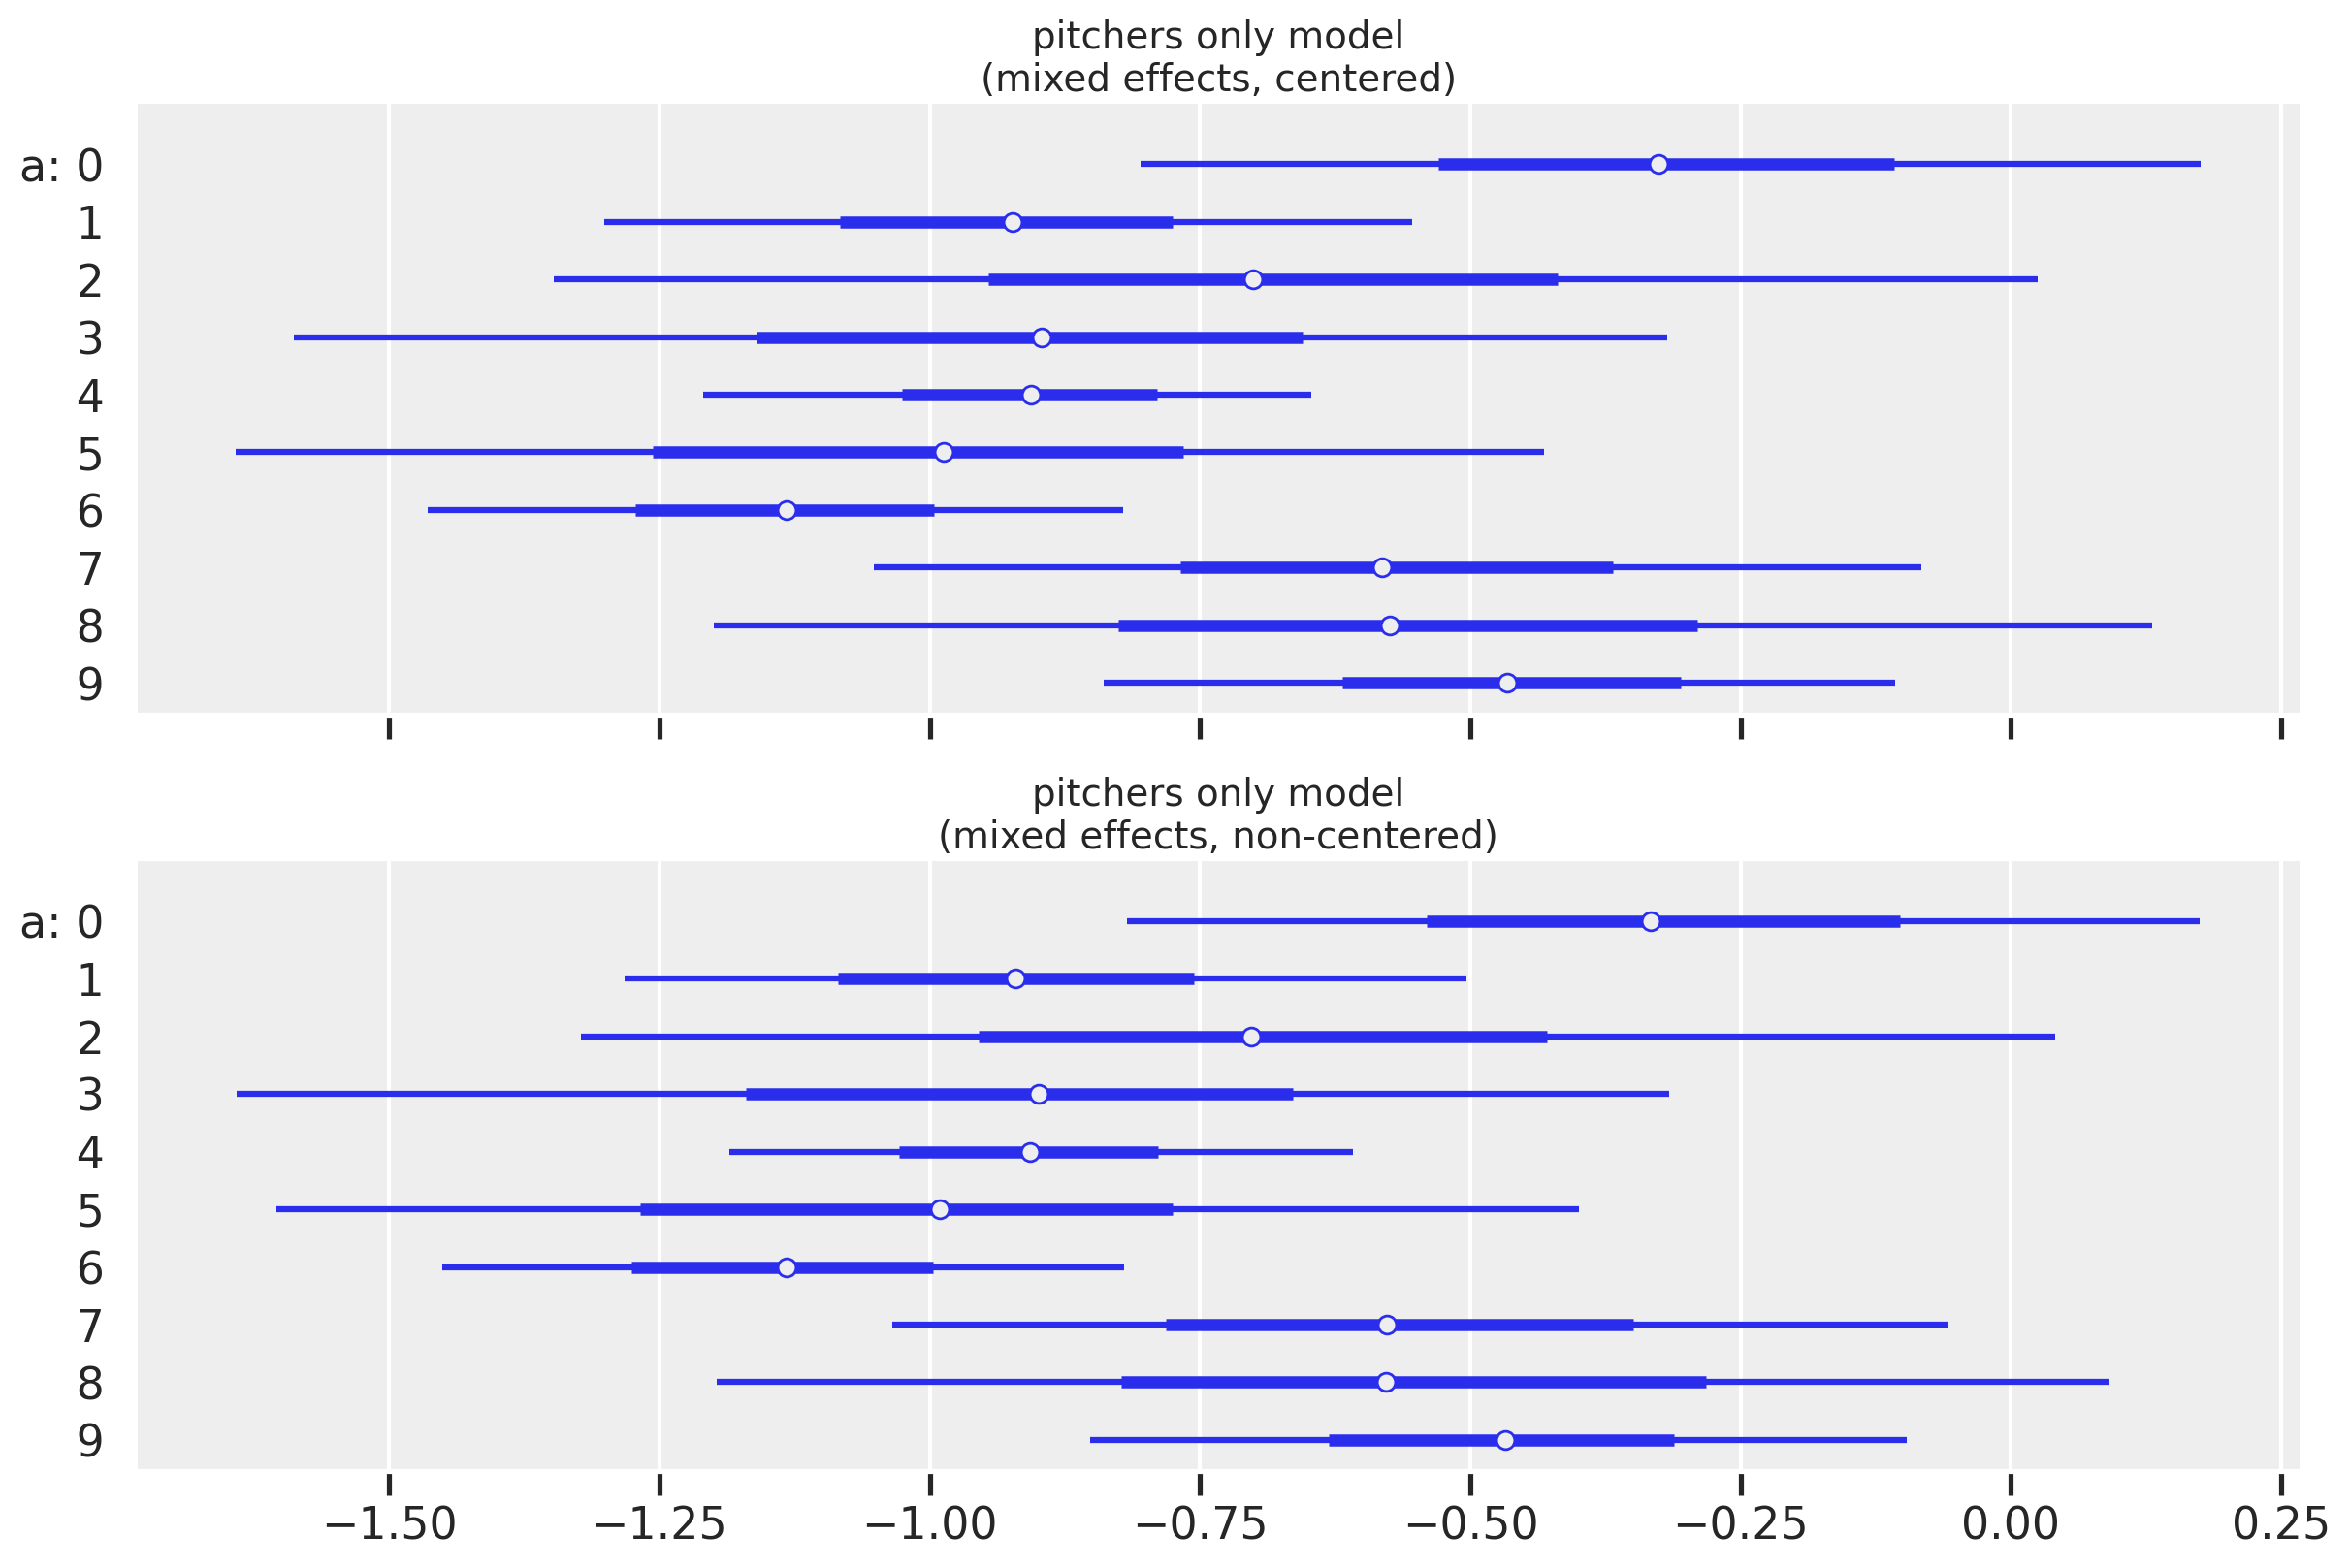

<IPython.core.display.Javascript object>

In [248]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
az.plot_forest(trace_m2, var_names=["a"], combined=True, ax=ax1)
az.plot_forest(trace_m3, var_names=["a"], combined=True, ax=ax2)

ax1.set_title("pitchers only model\n(mixed effects, centered)", size=14)
ax2.set_title("pitchers only model\n(mixed effects, non-centered)", size=14)
# ax1.set_yticks(np.linspace(0, 7.5, n_pitcher))
# ax1.set_yticklabels(sorted(df_padres["pitcher"].unique())[::-1], fontsize=10)
# ax1.set_xlabel("log-odds\n(on-base event)")

**Scatter plot of effective sample sizes (centered vs. non-centered)**

## Comparison of fixed and mixed effects models

In [225]:
df_summary_m1 = az.summary(trace_m1)
df_summary_m2 = az.summary(trace_m2)
col2keep = ["mean", "sd", "hdi_5.5%", "hdi_94.5%"]
df_summary = pd.merge(
    df_summary_m1[col2keep],
    df_summary_m2[col2keep],
    left_index=True,
    right_index=True,
    how="inner",
)
# Bring them in the same dataframe
# x is the fixed effects model
# y is the mixed effects model
df_summary["vars"] = df_summary.index
df_summary.reset_index(drop=True, inplace=True)

# Add sample sizes (total at-bats) to the dataframe
df_summary["total_ab"] = (
    df_padres.groupby("pitcher").sum()["n_ab"].reset_index(drop=True)
)
df_summary.head()

,mean_x,sd_x,hdi_5.5%_x,hdi_94.5%_x,mean_y,sd_y,hdi_5.5%_y,hdi_94.5%_y,vars,total_ab
0,0.004,0.334,-0.559,0.499,-0.671,0.191,-0.963,-0.365,a[0],36
1,-1.017,0.286,-1.449,-0.547,-0.840,0.158,-1.088,-0.583,a[1],64
2,-0.402,0.864,-1.757,0.943,-0.779,0.191,-1.054,-0.457,a[2],5
3,-1.329,0.735,-2.477,-0.118,-0.809,0.181,-1.081,-0.517,a[3],10
4,-0.951,0.198,-1.272,-0.639,-0.841,0.133,-1.063,-0.637,a[4],129


<IPython.core.display.Javascript object>

[Text(0, 0, "('arrieta', 'jake')"),
 Text(0, 1, "('darvish', 'yu')"),
 Text(0, 2, "('johnson', 'pierce')"),
 Text(0, 3, "('knehr', 'reiss')"),
 Text(0, 4, "('musgrove', 'joe')"),
 Text(0, 5, "('paddack', 'chris')"),
 Text(0, 6, "('snell', 'blake')"),
 Text(0, 7, "('stammen', 'craig')"),
 Text(0, 8, "('strahm', 'matt')"),
 Text(0, 9, "('weathers', 'ryan')")]

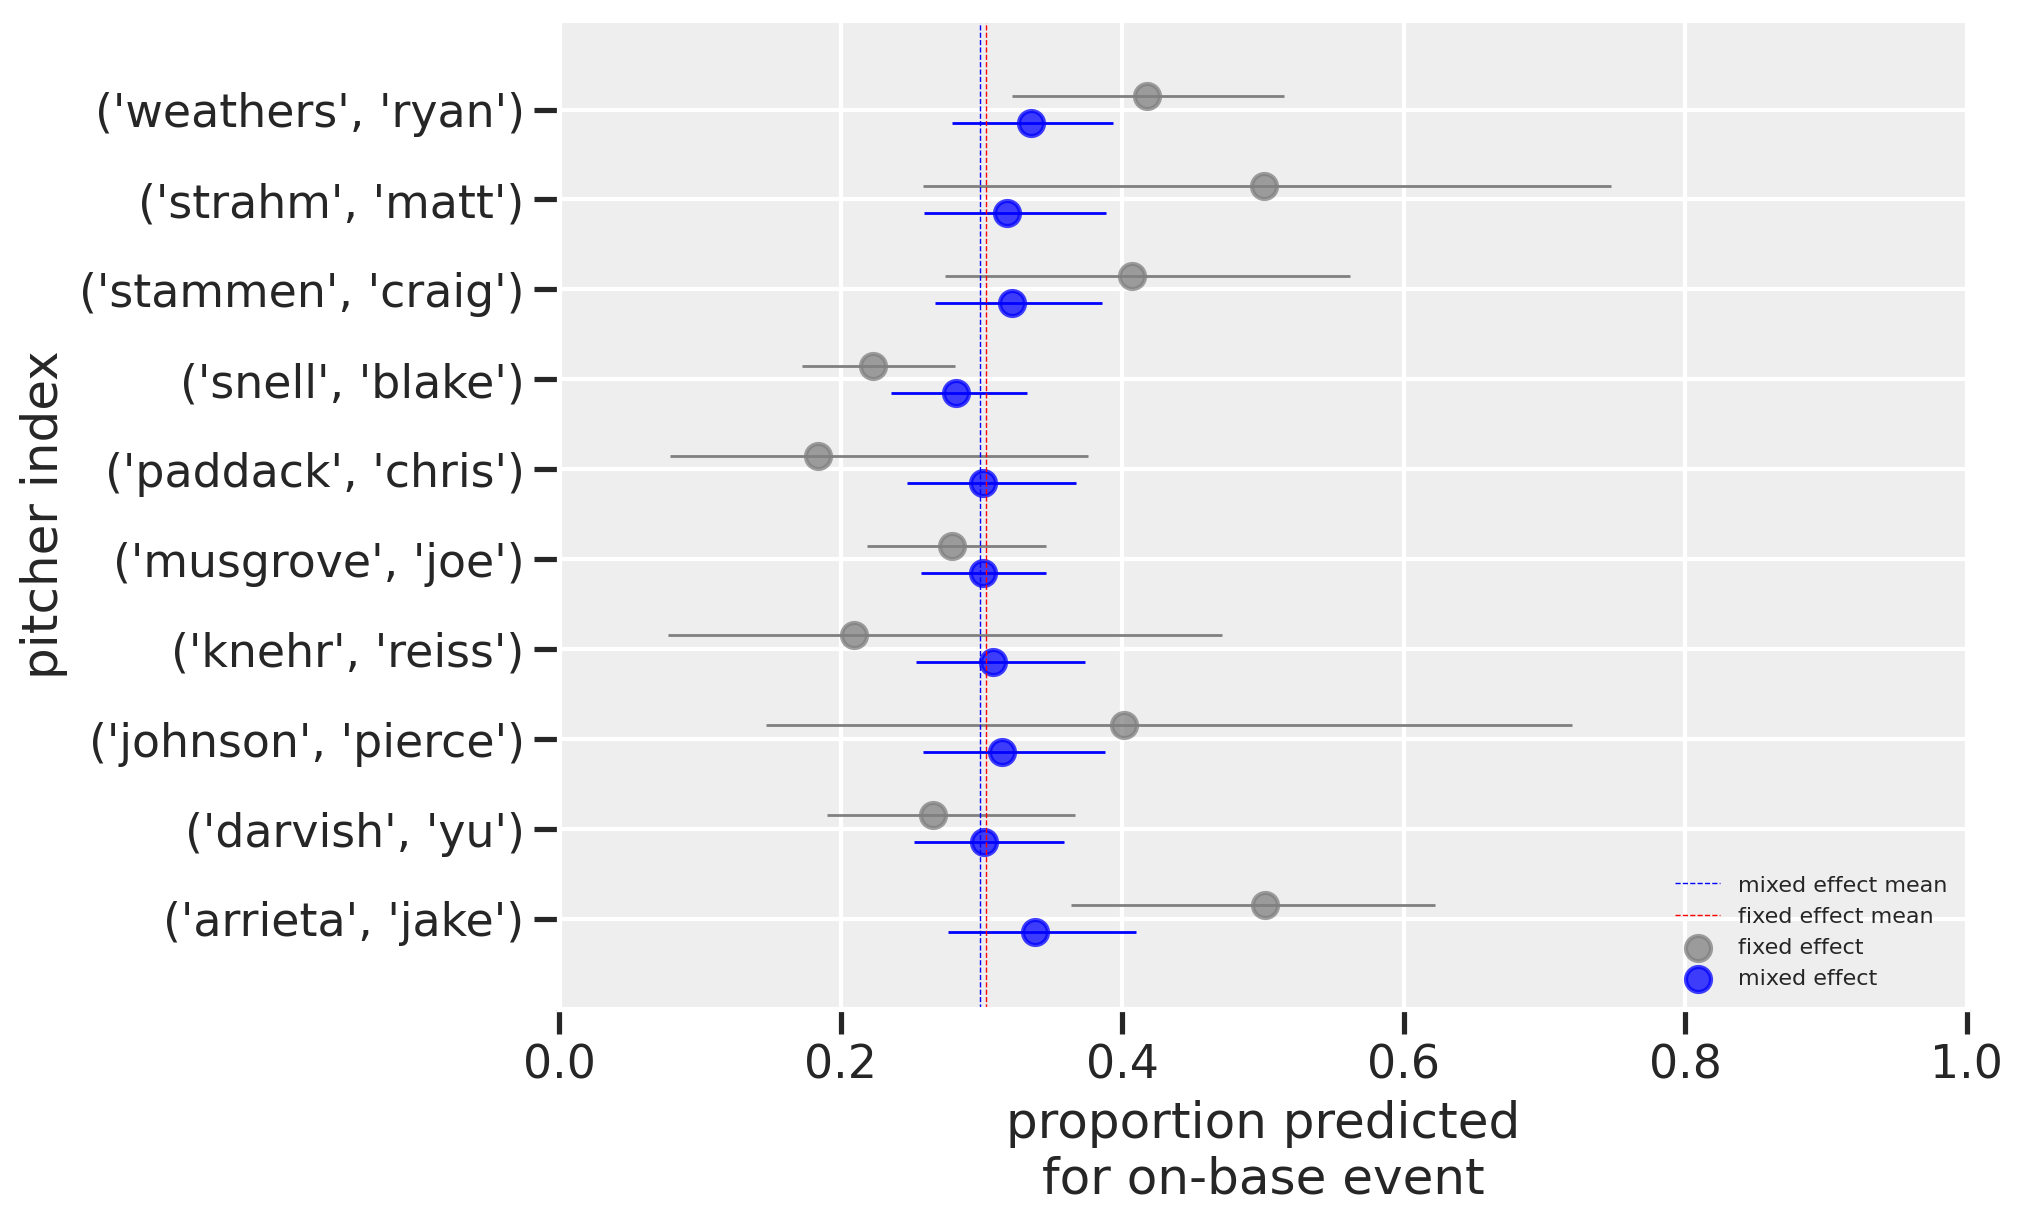

<IPython.core.display.Javascript object>

In [219]:
f, ax1 = plt.subplots(1, 1, figsize=(10, 6))
df_summary_Ponly = df_summary[df_summary["vars"].str.contains("a")]

# Plot means
ax1.scatter(
    logistic(df_summary_Ponly["mean_x"]),
    df_summary_Ponly.index + 0.15,
    color="gray",
    alpha=0.75,
    label="fixed effect",
)

ax1.scatter(
    logistic(df_summary_Ponly["mean_y"]),
    df_summary_Ponly.index - 0.15,
    color="blue",
    alpha=0.75,
    label="mixed effect",
)

# Plot uncertainties
ax1.hlines(
    y=df_summary_Ponly.index + 0.15,
    xmin=logistic(df_summary_Ponly["hdi_5.5%_x"]),
    xmax=logistic(df_summary_Ponly["hdi_94.5%_x"]),
    color="gray",
    linewidth=1,
)

ax1.hlines(
    y=df_summary_Ponly.index - 0.15,
    xmin=logistic(df_summary_Ponly["hdi_5.5%_y"]),
    xmax=logistic(df_summary_Ponly["hdi_94.5%_y"]),
    color="blue",
    linewidth=1,
)


# Plot average mixed effect line
me_mean = logistic(az.summary(trace_m3).loc["a_bar", "mean"])
ax1.plot(
    [me_mean, me_mean],
    [-1, 10],
    color="blue",
    lw=0.5,
    linestyle="--",
    alpha=1,
    label="mixed effect mean",
)

# Plot raw fixed effect line
fe_mean = df_padres["n_ob"].sum() / df_padres["n_ab"].sum()
ax1.plot(
    [fe_mean, fe_mean],
    [-1, 10],
    color="red",
    lw=0.5,
    linestyle="--",
    alpha=1,
    label="fixed effect mean",
)

ax1.legend(loc="lower right", fontsize=8)
ax1.set(
    xlim=[0, 1],
    ylim=[-1, 10],
    xlabel="proportion predicted\nfor on-base event",
    ylabel="pitcher index",
)

ax1.set_yticks(range(10))
ax1.set_yticklabels(df_pitcher_code["pitcher"])

In [217]:
df_padres["n_ob"].sum() / df_padres["n_ab"].sum()

0.30278884462151395

<IPython.core.display.Javascript object>

In [226]:
df_summary

,mean_x,sd_x,hdi_5.5%_x,hdi_94.5%_x,mean_y,sd_y,hdi_5.5%_y,hdi_94.5%_y,vars,total_ab
0,0.004,0.334,-0.559,0.499,-0.671,0.191,-0.963,-0.365,a[0],36
1,-1.017,0.286,-1.449,-0.547,-0.840,0.158,-1.088,-0.583,a[1],64
2,-0.402,0.864,-1.757,0.943,-0.779,0.191,-1.054,-0.457,a[2],5
3,-1.329,0.735,-2.477,-0.118,-0.809,0.181,-1.081,-0.517,a[3],10
4,-0.951,0.198,-1.272,-0.639,-0.841,0.133,-1.063,-0.637,a[4],129
5,-1.491,0.623,-2.459,-0.507,-0.841,0.181,-1.116,-0.544,a[5],17
6,-1.249,0.200,-1.571,-0.939,-0.937,0.155,-1.176,-0.698,a[6],139
7,-0.377,0.393,-0.973,0.249,-0.745,0.173,-1.010,-0.467,a[7],27
8,0.003,0.685,-1.053,1.085,-0.763,0.189,-1.049,-0.455,a[8],8
9,-0.333,0.248,-0.745,0.059,-0.686,0.166,-0.948,-0.432,a[9],67


<IPython.core.display.Javascript object>

[(0.0, 0.884),
 (0.0, 0.884),
 Text(0.5, 0, 'fixed effects SD'),
 Text(0, 0.5, 'mixed effects SD')]

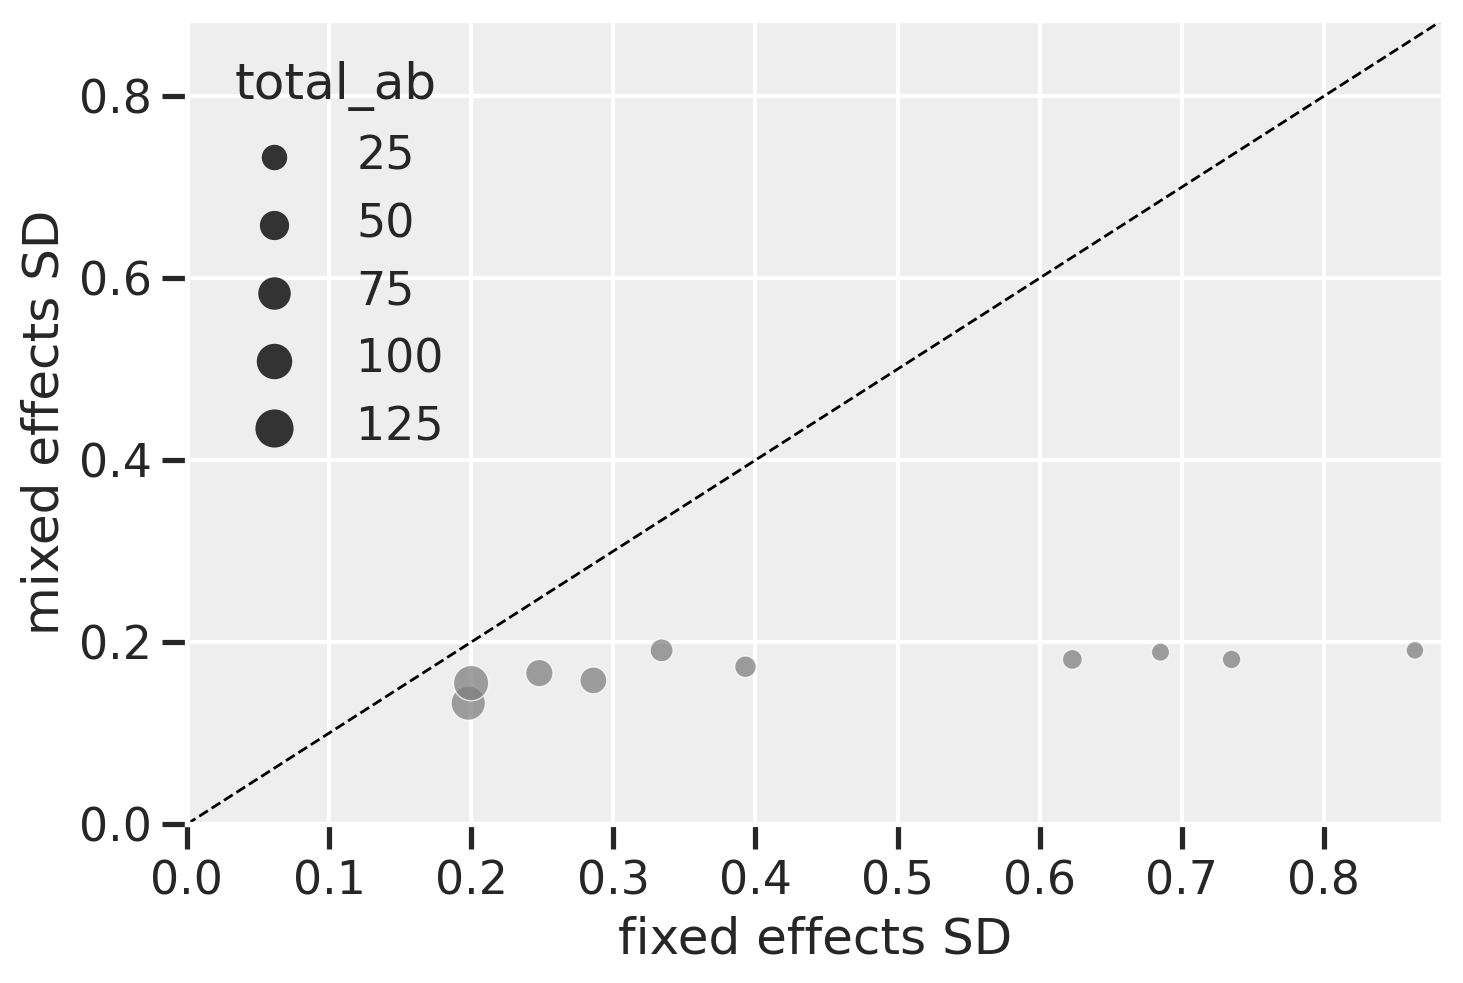

<IPython.core.display.Javascript object>

In [234]:
max_sd = df_summary[["sd_x", "sd_y"]].max().max()

f, ax1 = plt.subplots()
sns.scatterplot(
    data=df_summary,
    x="sd_x",
    y="sd_y",
    size="total_ab",
    color="gray",
    ax=ax1,
    alpha=0.75,
)
ax1.plot([0, max_sd + 0.02], [0, max_sd + 0.02], color="black", lw=1, linestyle="--")
ax1.set(
    xlim=[0, max_sd + 0.02],
    ylim=[0, max_sd + 0.02],
    xlabel="fixed effects SD",
    ylabel="mixed effects SD",
)

# `Pitcher` and `Coach` models
Let's look at a fixed effects with an intercept-only model of just pitcher.

## Fixed effects

**Model `m1` equation**

$$O_i \sim \text{Binomial}(n_i, p_i) \tag{O for number of on-base events}$$

$$\text{logit}(p_i) = \alpha_{\text{PITCHER}[i]} + \gamma_{\text{COACH}[i]} \tag{pitcher and coach, encoded as an index variables}$$

$$\alpha_j \sim \text{Normal}(0, 2) \tag{regularizing prior for each pitcher}$$

$$\gamma_j \sim \text{Normal}(0, 2) \tag{regularizing prior for each coach}$$

In [183]:
df_padres.head()

,pitcher,game_date,n_ab,n_ob,obp,pitching_coach,pitcher_code,pitching_coach_code,coach_code
0,"('knehr', 'reiss')",2021-08-01,10,2,0.200000,Rothschild,3,0,0
1,"('snell', 'blake')",2021-08-03,23,9,0.391304,Rothschild,6,0,0
2,"('musgrove', 'joe')",2021-08-04,24,7,0.291667,Rothschild,4,0,0
3,"('arrieta', 'jake')",2021-08-05,19,9,0.473684,Rothschild,0,0,0
4,"('weathers', 'ryan')",2021-08-06,16,8,0.500000,Rothschild,9,0,0


<IPython.core.display.Javascript object>

In [43]:
# modified from repo
with pm.Model() as m1:
    # regularizing priors
    a = pm.Normal("a", 0.0, 2, shape=n_pitcher)
    g = pm.Normal("g", 0.0, 2, shape=n_coach)
    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]] + g[df_padres["coach_code"]])
    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])
    # sample
    trace_m1 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, a]
INFO:pymc3:NUTS: [g, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [44]:
df_summary1 = az.summary(trace_m1)
df_summary1

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],0.339,0.691,-0.832,1.408,0.026,0.019,689.0,689.0,693.0,1415.0,1.01
a[1],-0.419,0.671,-1.541,0.600,0.025,0.018,712.0,712.0,713.0,1154.0,1.01
a[2],0.543,0.988,-1.006,2.163,0.025,0.018,1505.0,1505.0,1508.0,2225.0,1.00
a[3],-1.024,0.919,-2.441,0.424,0.026,0.019,1229.0,1229.0,1233.0,1556.0,1.01
a[4],-0.434,0.642,-1.559,0.497,0.026,0.018,612.0,612.0,611.0,993.0,1.01
a[5],-0.471,0.851,-1.865,0.833,0.027,0.019,1023.0,1023.0,1019.0,1897.0,1.00
a[6],-0.670,0.637,-1.725,0.311,0.025,0.017,670.0,670.0,671.0,1153.0,1.01
a[7],-0.045,0.714,-1.230,1.056,0.025,0.018,802.0,802.0,803.0,1710.0,1.00
a[8],0.298,0.919,-1.223,1.732,0.027,0.019,1132.0,1132.0,1131.0,2023.0,1.01
a[9],0.139,0.646,-0.900,1.163,0.025,0.018,648.0,648.0,636.0,1152.0,1.01


<IPython.core.display.Javascript object>

In [69]:
sorted(df_padres["pitcher"].unique())

["('arrieta', 'jake')",
 "('darvish', 'yu')",
 "('johnson', 'pierce')",
 "('knehr', 'reiss')",
 "('musgrove', 'joe')",
 "('paddack', 'chris')",
 "('snell', 'blake')",
 "('stammen', 'craig')",
 "('strahm', 'matt')",
 "('weathers', 'ryan')"]

<IPython.core.display.Javascript object>

[Text(0, 0.0, 'Fritz'), Text(0, 0.75, 'Rothschild')]

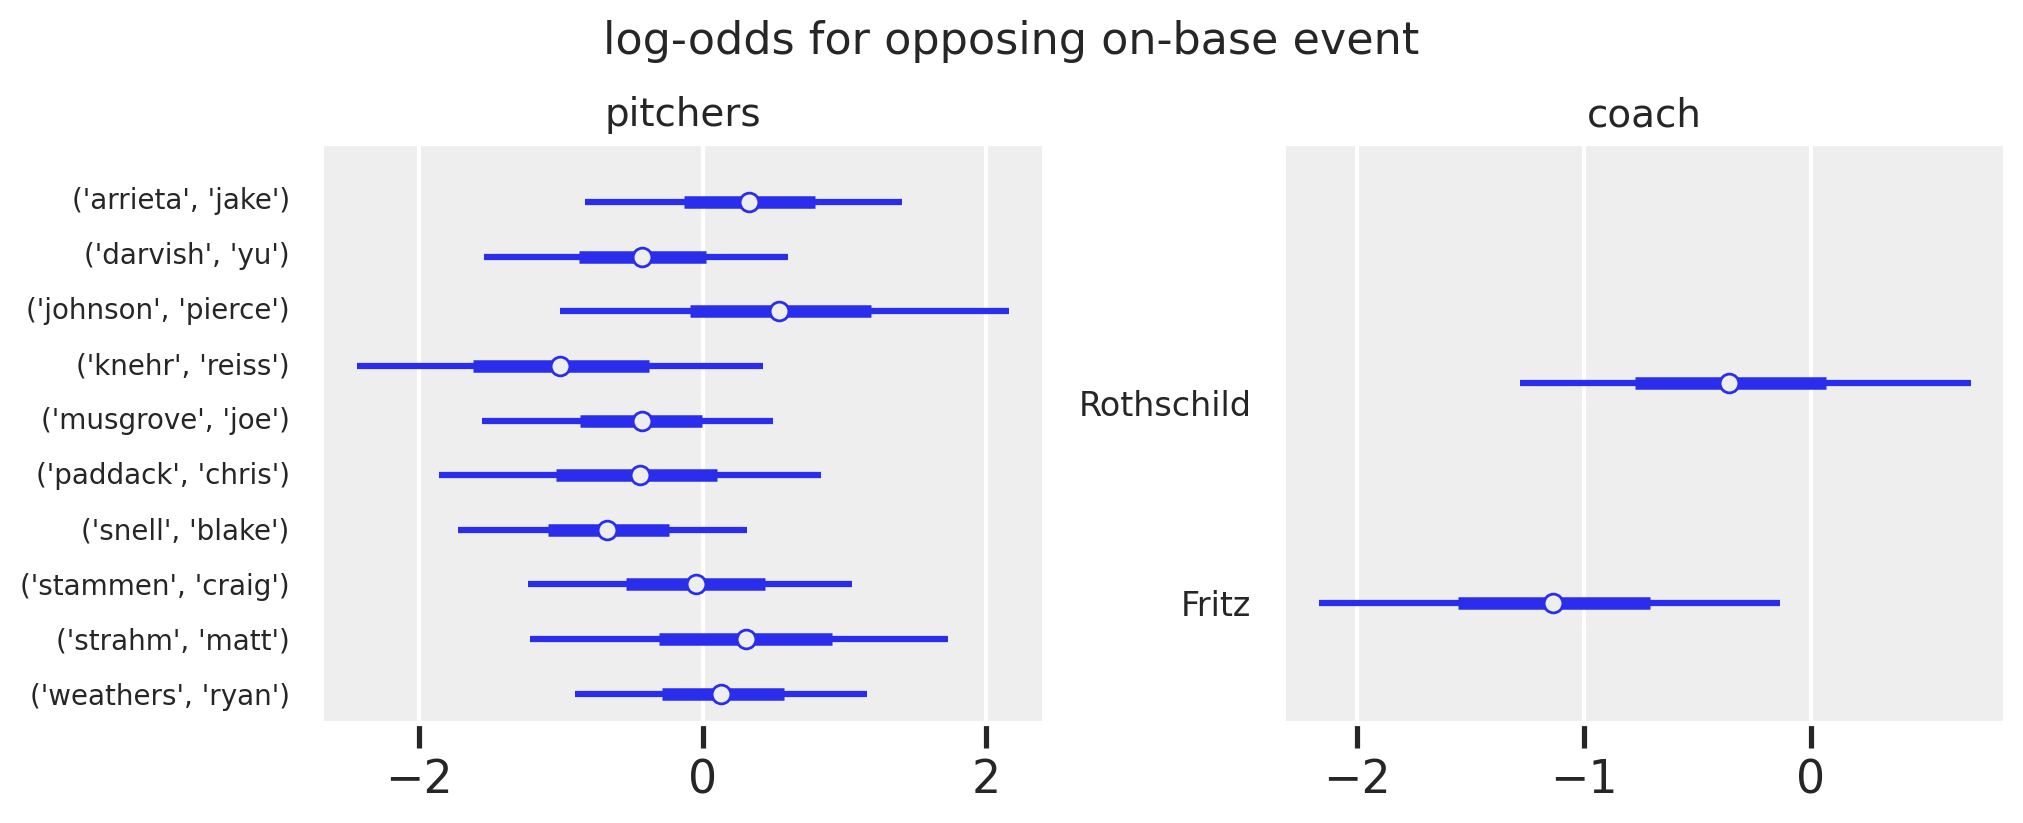

<IPython.core.display.Javascript object>

In [130]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
az.plot_forest(trace_m1, var_names="a", combined=True, ax=ax1)
az.plot_forest(trace_m1, var_names="g", combined=True, ax=ax2)
f.suptitle("log-odds for opposing on-base event", size=16)
ax1.set_title("pitchers", size=14)
ax2.set_title("coach", size=14)
# ax1.set_yticks(range(n_pitcher))  # labels not lining up
ax1.set_yticks(np.linspace(0, 7.5, n_pitcher))
ax1.set_yticklabels(sorted(df_padres["pitcher"].unique())[::-1], fontsize=10)
# ax2.set_yticks(range(n_coach))
ax2.set_yticks([0, 0.75])
ax2.set_yticklabels(["Fritz", "Rothschild"], fontsize=12)

Here you can get a general sense of pitcher performance but one thing I'd like to highlight are the differences in the credible intervals for each pitcher. Those with the fewest number of opposing at-bats (Johnson, Knehr, and Strahm) also have the widest intervals, reflecting greater uncertainty. Those with the most (Musgrove, Darvish, and Snell) have the thinnest interval. 

As for the coach, we see some difference in the estimate of the on-base event. The width of the credible interval is not noticeably different, despite the total number of at-bats with them at the coaching helm (Rothschild coached for 363 opposing at-bats and Fritz had 139).

The difference in sample size for pitcher can be addressed with a mixed effect model, which we'll do next.

## Mixed effects

The cool thing about mixed effect models is their use of adaptive priors. This allows *sharing* of information between pitchers. We can get better estimates, especially for starting pitchers that have not faced many opposing batters by learning from the performance of other pitchers. Some information sharing will also happen with the coach variable. Here is what a mixed effect model looks like.

### Centered paramaterization

**Model `m2` equation**

$$O_i \sim \text{Binomial}(n_i, p_i) \tag{O for number of on-base events}$$

$$\text{logit}(p_i) = \alpha_{\text{PITCHER}[i]} + \gamma_{\text{COACH}[i]} \tag{pitcher and coach, encoded as index variables}$$

$$\alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma_{\alpha}) \tag{adaptive prior for pitcher}$$

$$\gamma_j \sim \text{Normal}(0, \sigma_{\gamma}) \tag{adaptive prior for coach}$$

$$\bar{\alpha} \sim \text{Normal}(0, 1.5) \tag{prior for average pitcher}$$

$$\sigma_{\alpha} \sim \text{HalfNormal}(0,1) \tag{prior for SD of pitchers}$$

$$\sigma_{\gamma} \sim \text{HalfNormal}(0,1) \tag{prior for SD of pitchers}$$

Note how there's no separate \(\bar{\gamma}\) prior. The \(\bar{\alpha}\) term is sufficient since we can't identify a separate mean for both the pitcher and coach intercept type.

In [249]:
with pm.Model() as m4:

    # prior for SD of pitchers, coaches
    sigma_a = pm.HalfNormal("sigma_a", sigma=1)
    sigma_g = pm.HalfNormal("sigma_g", sigma=1)

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 1.5)

    # adaptive priors
    a = pm.Normal("a", a_bar, sigma_a, shape=n_pitcher)
    g = pm.Normal("g", 0, sigma_g, shape=n_coach)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]] + g[df_padres["coach_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # increased tune and target accept from other testing
    trace_m4 = pm.sample(
        draws=1000,
        random_seed=19,
        tune=2000,
        return_inferencedata=True,
        target_accept=0.95,
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [g, a, a_bar, sigma_g, sigma_a]
INFO:pymc3:NUTS: [g, a, a_bar, sigma_g, sigma_a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 25 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 25 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for

<IPython.core.display.Javascript object>

Pymc gives us some warnings about divergent transitions. This may not impact our findings significantly, but means that there is some inefficiency in exploring the posterior distribution and possibly some regions that are hard to explore and obtain samples. This tends to happen when the distribution of one variable is depednent on another, which is common in multilevel models (in this case \(\alpha_{j}\) is dependent on \(\bar{\alpha}\)).

I already applied two easy tricks for reducing the impact of divergent transitions by increasing the `tune` and `targe_accept` parameters. The next thing we can try is **re-paramaterization** of the model into a "non-centered" form. The model as shown above is called a "centered" form.

### Non-centered paramaterization

The non-centered paramaterization uses transformation to sample a variable with a posterior distribution that is easier to explore. We then transform back to get the desired parameters and so in the end it is mathematically equivalent.

While we won't use the centered paramterization within the pymc block of code, I'm showing it here in the model equation so that you can better see the transformation.

**Model `m3` equation**

$$O_i \sim \text{Binomial}(n_i, p_i) \tag{O for number of on-base events}$$

$$\text{logit}(p_i) = \alpha_{\text{PITCHER}[i]} + \gamma_{\text{COACH}[i]} \tag{centered parameterization for comparison}$$

$$\text{logit}(p_i) = \bar{\alpha} + z_{\text{PITCHER}[i]}\sigma_{\alpha} + x_{\text{COACH}[i]}\sigma_{\gamma} \tag{non-centered parameterization}$$

$$z_j \sim \text{Normal}(0, 1) \tag{standardized intercepts for pitcher}$$

$$x_j \sim \text{Normal}(0, 1) \tag{standardized intercept for coach}$$

$$\bar{\alpha} \sim \text{Normal}(0, 1.5) \tag{prior for average pitcher}$$

$$\sigma_{\alpha} \sim \text{HalfNormal}(0,1) \tag{prior for SD of pitchers}$$

$$\sigma_{\gamma} \sim \text{HalfNormal}(0,1) \tag{prior for SD of pitchers}$$

In [138]:
# Looked at repo code for R 13.29
with pm.Model() as m3:

    a_bar = pm.Normal("a_bar", 0, 1.5)
    sigma_a = pm.HalfNormal("sigma_a", sigma=1)
    sigma_g = pm.HalfNormal("sigma_g", sigma=1)

    z = pm.Normal("z", 0, 1, shape=n_pitcher)
    x = pm.Normal("x", 0, 1, shape=n_coach)

    # non-centered version, but not being used
    _ = pm.Deterministic("a", a_bar + z * sigma_a)
    _ = pm.Deterministic("g", x * sigma_g)

    # linear model
    p = pm.math.invlogit(
        a_bar
        + z[df_padres["pitcher_code"]] * sigma_a
        + x[df_padres["coach_code"]] * sigma_g
    )

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample
    trace_m3 = pm.sample(
        draws=1000,
        random_seed=19,
        tune=2000,
        target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, z, sigma_g, sigma_a, a_bar]
INFO:pymc3:NUTS: [x, z, sigma_g, sigma_a, a_bar]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 28 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 28 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

As you can see, we have no more divergence warnings! We can work with the model with the results from the non-centered parameterization to compare the results from the fixed and mixed effects models.

## Comparison of fixed-effects and mixed-effects models

The first thing we can do is plot the posterior distributions of the parameters for each pitcher and coach, with the fixed and mixed effects models. To visualize this clearly, we'll have to do some of our own coding instead of relying on arviz's `plot_forest` function.

In [155]:
df_summary_m1 = az.summary(trace_m1)
df_summary_m3 = az.summary(trace_m3)
col2keep = ["mean", "sd", "hdi_5.5%", "hdi_94.5%"]
df_summary = pd.merge(
    df_summary_m1[col2keep],
    df_summary_m3[col2keep],
    left_index=True,
    right_index=True,
    how="inner",
)
# Bring them in the same dataframe
# x is the fixed effects model
# y is the mixed effects model
df_summary["vars"] = df_summary.index
df_summary.reset_index(drop=True, inplace=True)
df_summary.head()

,mean_x,sd_x,hdi_5.5%_x,hdi_94.5%_x,mean_y,sd_y,hdi_5.5%_y,hdi_94.5%_y,vars
0,0.339,0.691,-0.832,1.408,-0.605,0.616,-1.588,0.364,a[0]
1,-0.419,0.671,-1.541,0.600,-0.967,0.588,-1.956,-0.080,a[1]
2,0.543,0.988,-1.006,2.163,-0.755,0.665,-1.747,0.374,a[2]
3,-1.024,0.919,-2.441,0.424,-1.014,0.646,-2.007,0.010,a[3]
4,-0.434,0.642,-1.559,0.497,-0.997,0.572,-1.963,-0.176,a[4]


<IPython.core.display.Javascript object>

[(0.0, 1.0),
 (-1.0, 10.0),
 Text(0.5, 0, 'proportion predicted\nfor on-base event'),
 Text(0, 0.5, 'pitcher index')]

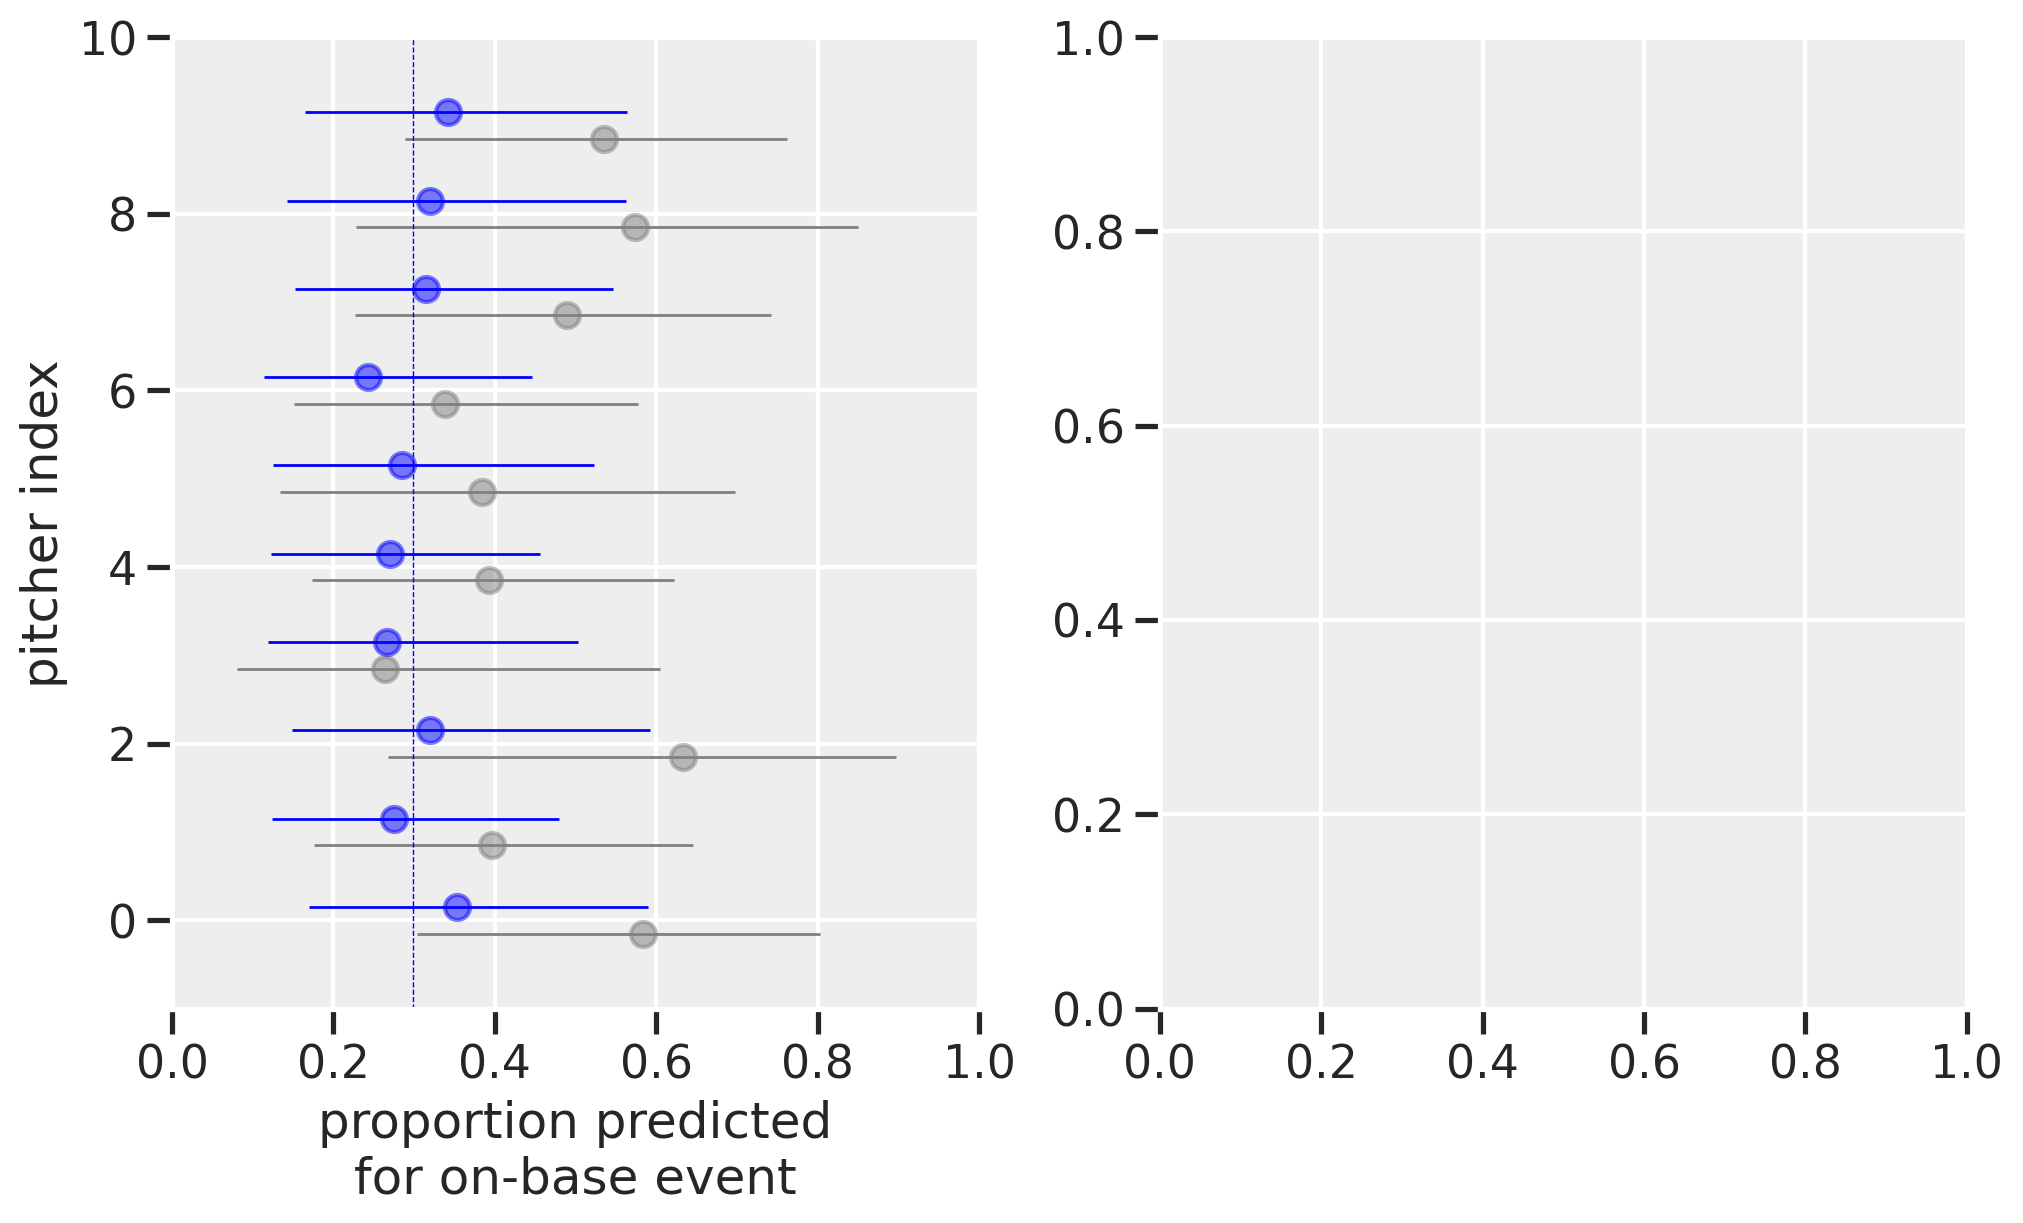

<IPython.core.display.Javascript object>

In [168]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Use ax1 for pitchers, ax2 for coaches
df_summary_pitcher = df_summary[df_summary["vars"].str.contains("a")]
df_summary_coach = df_summary[df_summary["vars"].str.contains("g")]

# Plot means
ax1.scatter(
    logistic(df_summary_pitcher["mean_x"]),
    df_summary_pitcher.index - 0.15,
    color="gray",
    alpha=0.5,
    label="fixed effect",
)

ax1.scatter(
    logistic(df_summary_pitcher["mean_y"]),
    df_summary_pitcher.index + 0.15,
    color="blue",
    alpha=0.5,
    label="mixed effect",
)

# Plot uncertainties
ax1.hlines(
    y=df_summary_pitcher.index - 0.15,
    xmin=logistic(df_summary_pitcher["hdi_5.5%_x"]),
    xmax=logistic(df_summary_pitcher["hdi_94.5%_x"]),
    color="gray",
    linewidth=1,
)

ax1.hlines(
    y=df_summary_pitcher.index + 0.15,
    xmin=logistic(df_summary_pitcher["hdi_5.5%_y"]),
    xmax=logistic(df_summary_pitcher["hdi_94.5%_y"]),
    color="blue",
    linewidth=1,
)


# Plot average mixed effect line
me_mean = logistic(az.summary(trace_m3).loc["a_bar", "mean"])
ax1.plot(
    [me_mean, me_mean],
    [-1, 10],
    color="blue",
    lw=0.5,
    linestyle="--",
    alpha=1,
    label="mixed effect mean",
)

# Plot raw fixed effect line
# fe_mean = df_bangladesh["use.contraception"].mean()
# ax1.plot(
#     [-10, 62],
#     [fe_mean, fe_mean],
#     color="red",
#     lw=0.5,
#     linestyle="--",
#     alpha=1,
#     label="fixed effect mean",
# )


# ax1.legend()
ax1.set(
    xlim=[0, 1],
    ylim=[-1, 10],
    xlabel="proportion predicted\nfor on-base event",
    ylabel="pitcher index",
)

In [171]:
me_mean

0.29859443999451146

<IPython.core.display.Javascript object>

## Comparison with centered paramaterization

In [181]:
df_summary_m1 = az.summary(trace_m1)
df_summary_m2 = az.summary(trace_m2)
col2keep = ["mean", "sd", "hdi_5.5%", "hdi_94.5%"]
df_summary2 = pd.merge(
    df_summary_m1[col2keep],
    df_summary_m2[col2keep],
    left_index=True,
    right_index=True,
    how="inner",
)
# Bring them in the same dataframe
# x is the fixed effects model
# y is the mixed effects model
df_summary2["vars"] = df_summary2.index
df_summary2.reset_index(drop=True, inplace=True)
df_summary2.head()

,mean_x,sd_x,hdi_5.5%_x,hdi_94.5%_x,mean_y,sd_y,hdi_5.5%_y,hdi_94.5%_y,vars
0,0.339,0.691,-0.832,1.408,-0.637,0.478,-1.409,0.091,a[0]
1,-0.419,0.671,-1.541,0.600,-0.973,0.452,-1.722,-0.332,a[1]
2,0.543,0.988,-1.006,2.163,-0.802,0.519,-1.663,-0.046,a[2]
3,-1.024,0.919,-2.441,0.424,-1.000,0.508,-1.794,-0.224,a[3]
4,-0.434,0.642,-1.559,0.497,-1.010,0.437,-1.681,-0.323,a[4]


<IPython.core.display.Javascript object>

[Text(0, 0, "('arrieta', 'jake')"),
 Text(0, 1, "('darvish', 'yu')"),
 Text(0, 2, "('johnson', 'pierce')"),
 Text(0, 3, "('knehr', 'reiss')"),
 Text(0, 4, "('musgrove', 'joe')"),
 Text(0, 5, "('paddack', 'chris')"),
 Text(0, 6, "('snell', 'blake')"),
 Text(0, 7, "('stammen', 'craig')"),
 Text(0, 8, "('strahm', 'matt')"),
 Text(0, 9, "('weathers', 'ryan')")]

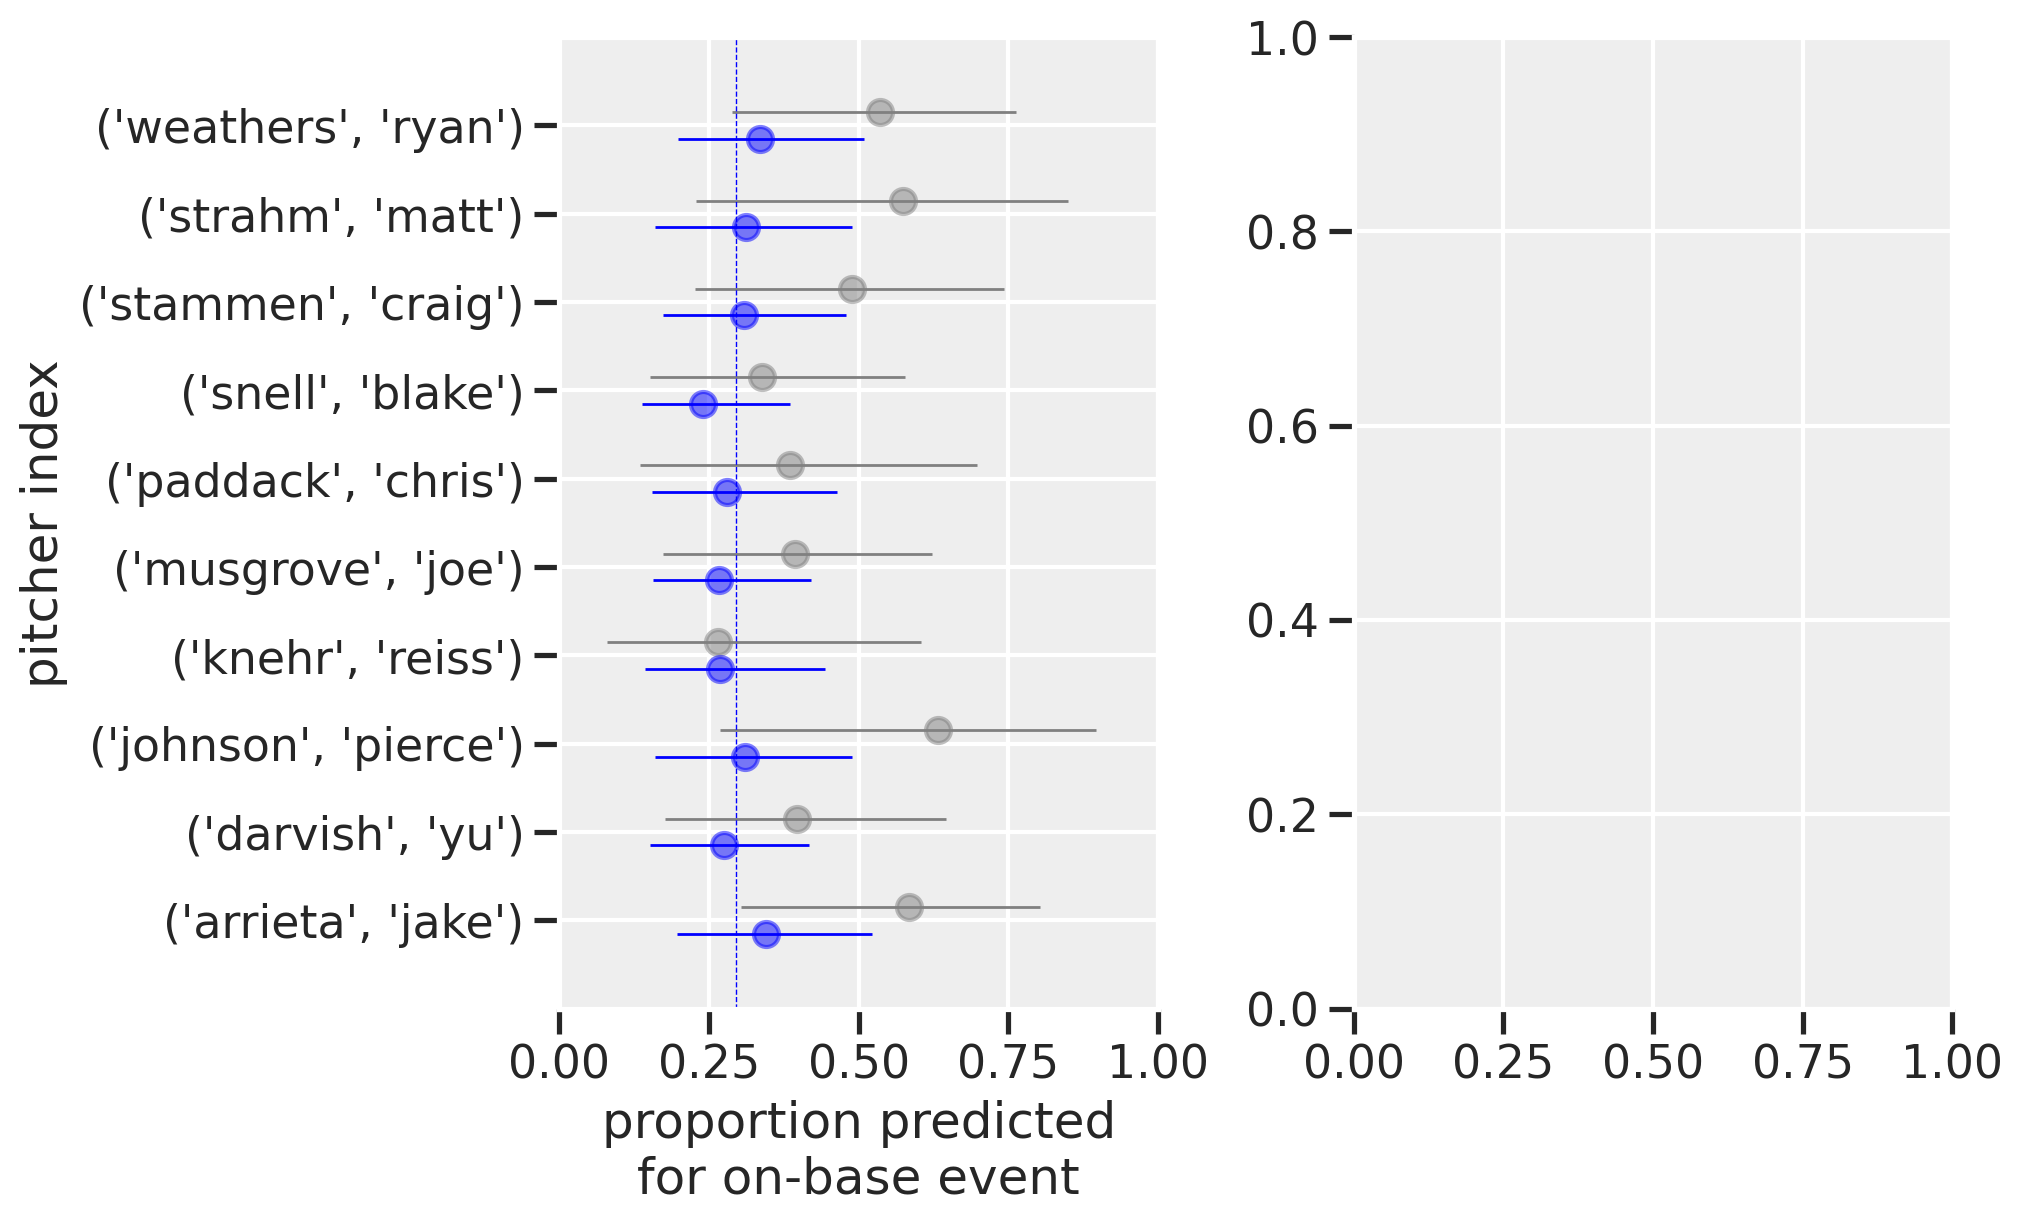

<IPython.core.display.Javascript object>

In [188]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Use ax1 for pitchers, ax2 for coaches
df_summary2_pitcher = df_summary2[df_summary2["vars"].str.contains("a")]
df_summary2_coach = df_summary2[df_summary2["vars"].str.contains("g")]

# Plot means
ax1.scatter(
    logistic(df_summary2_pitcher["mean_x"]),
    df_summary2_pitcher.index + 0.15,
    color="gray",
    alpha=0.5,
    label="fixed effect",
)

ax1.scatter(
    logistic(df_summary2_pitcher["mean_y"]),
    df_summary2_pitcher.index - 0.15,
    color="blue",
    alpha=0.5,
    label="mixed effect",
)

# Plot uncertainties
ax1.hlines(
    y=df_summary2_pitcher.index + 0.15,
    xmin=logistic(df_summary2_pitcher["hdi_5.5%_x"]),
    xmax=logistic(df_summary2_pitcher["hdi_94.5%_x"]),
    color="gray",
    linewidth=1,
)

ax1.hlines(
    y=df_summary2_pitcher.index - 0.15,
    xmin=logistic(df_summary2_pitcher["hdi_5.5%_y"]),
    xmax=logistic(df_summary2_pitcher["hdi_94.5%_y"]),
    color="blue",
    linewidth=1,
)


# Plot average mixed effect line
me_mean = logistic(az.summary(trace_m2).loc["a_bar", "mean"])
ax1.plot(
    [me_mean, me_mean],
    [-1, 10],
    color="blue",
    lw=0.5,
    linestyle="--",
    alpha=1,
    label="mixed effect mean",
)

# Plot raw fixed effect line
# fe_mean = df_bangladesh["use.contraception"].mean()
# ax1.plot(
#     [-10, 62],
#     [fe_mean, fe_mean],
#     color="red",
#     lw=0.5,
#     linestyle="--",
#     alpha=1,
#     label="fixed effect mean",
# )


# ax1.legend()
ax1.set(
    xlim=[0, 1],
    ylim=[-1, 10],
    xlabel="proportion predicted\nfor on-base event",
    ylabel="pitcher index",
)

ax1.set_yticks(range(10))
ax1.set_yticklabels(df_pitcher_code["pitcher"])

In [179]:
df_pitcher_code['pitcher']

,pitcher,pitcher_code
0,"('arrieta', 'jake')",0
1,"('darvish', 'yu')",1
2,"('johnson', 'pierce')",2
3,"('knehr', 'reiss')",3
4,"('musgrove', 'joe')",4
5,"('paddack', 'chris')",5
6,"('snell', 'blake')",6
7,"('stammen', 'craig')",7
8,"('strahm', 'matt')",8
9,"('weathers', 'ryan')",9


<IPython.core.display.Javascript object>

In [170]:
df_padres["n_ob"].sum() / df_padres["n_ab"].sum()

0.30278884462151395

<IPython.core.display.Javascript object>

In [167]:
logistic(az.summary(trace_m3).loc["a_bar", "mean"])

0.29859443999451146

<IPython.core.display.Javascript object>

[Text(0, 0.0, 'Fritz'), Text(0, 0.75, 'Rothschild')]

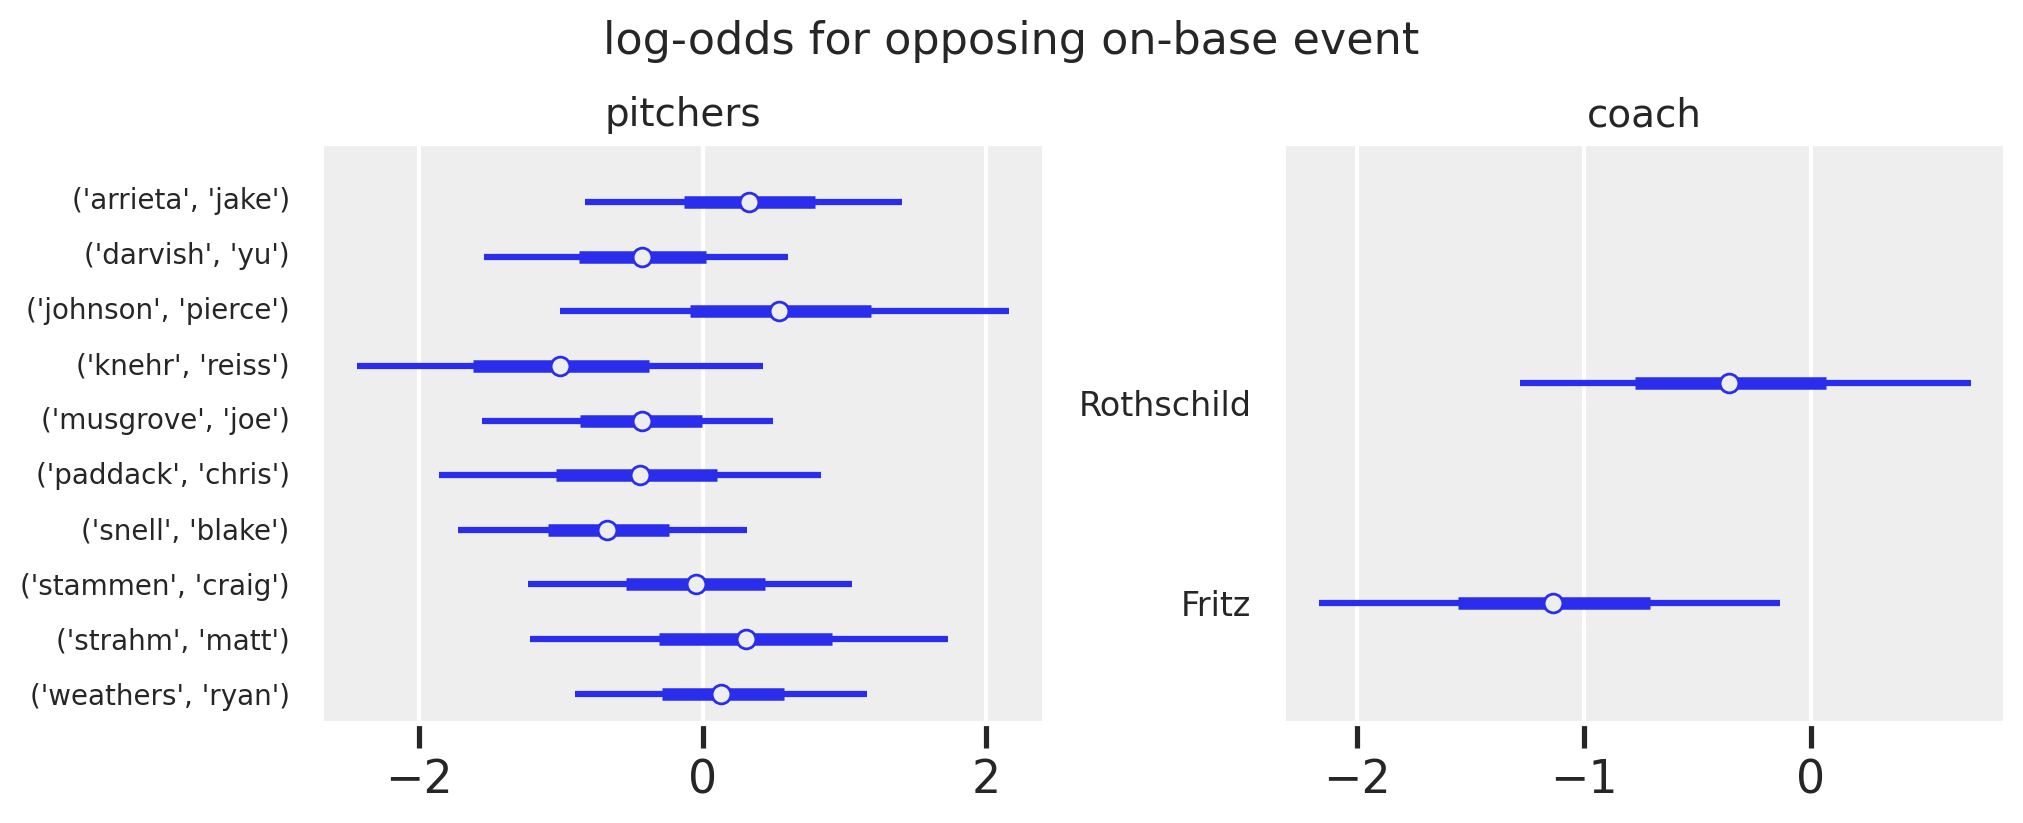

<IPython.core.display.Javascript object>

In [141]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
az.plot_forest(trace_m1, var_names="a", combined=True, ax=ax1)
az.plot_forest(trace_m1, var_names="g", combined=True, ax=ax2)
f.suptitle("log-odds for opposing on-base event", size=16)
ax1.set_title("pitchers", size=14)
ax2.set_title("coach", size=14)
# ax1.set_yticks(range(n_pitcher))  # labels not lining up
ax1.set_yticks(np.linspace(0, 7.5, n_pitcher))
ax1.set_yticklabels(sorted(df_padres["pitcher"].unique())[::-1], fontsize=10)
# ax2.set_yticks(range(n_coach))
ax2.set_yticks([0, 0.75])
ax2.set_yticklabels(["Fritz", "Rothschild"], fontsize=12)

[Text(0, 0.0, 'Fritz'), Text(0, 0.75, 'Rothschild')]

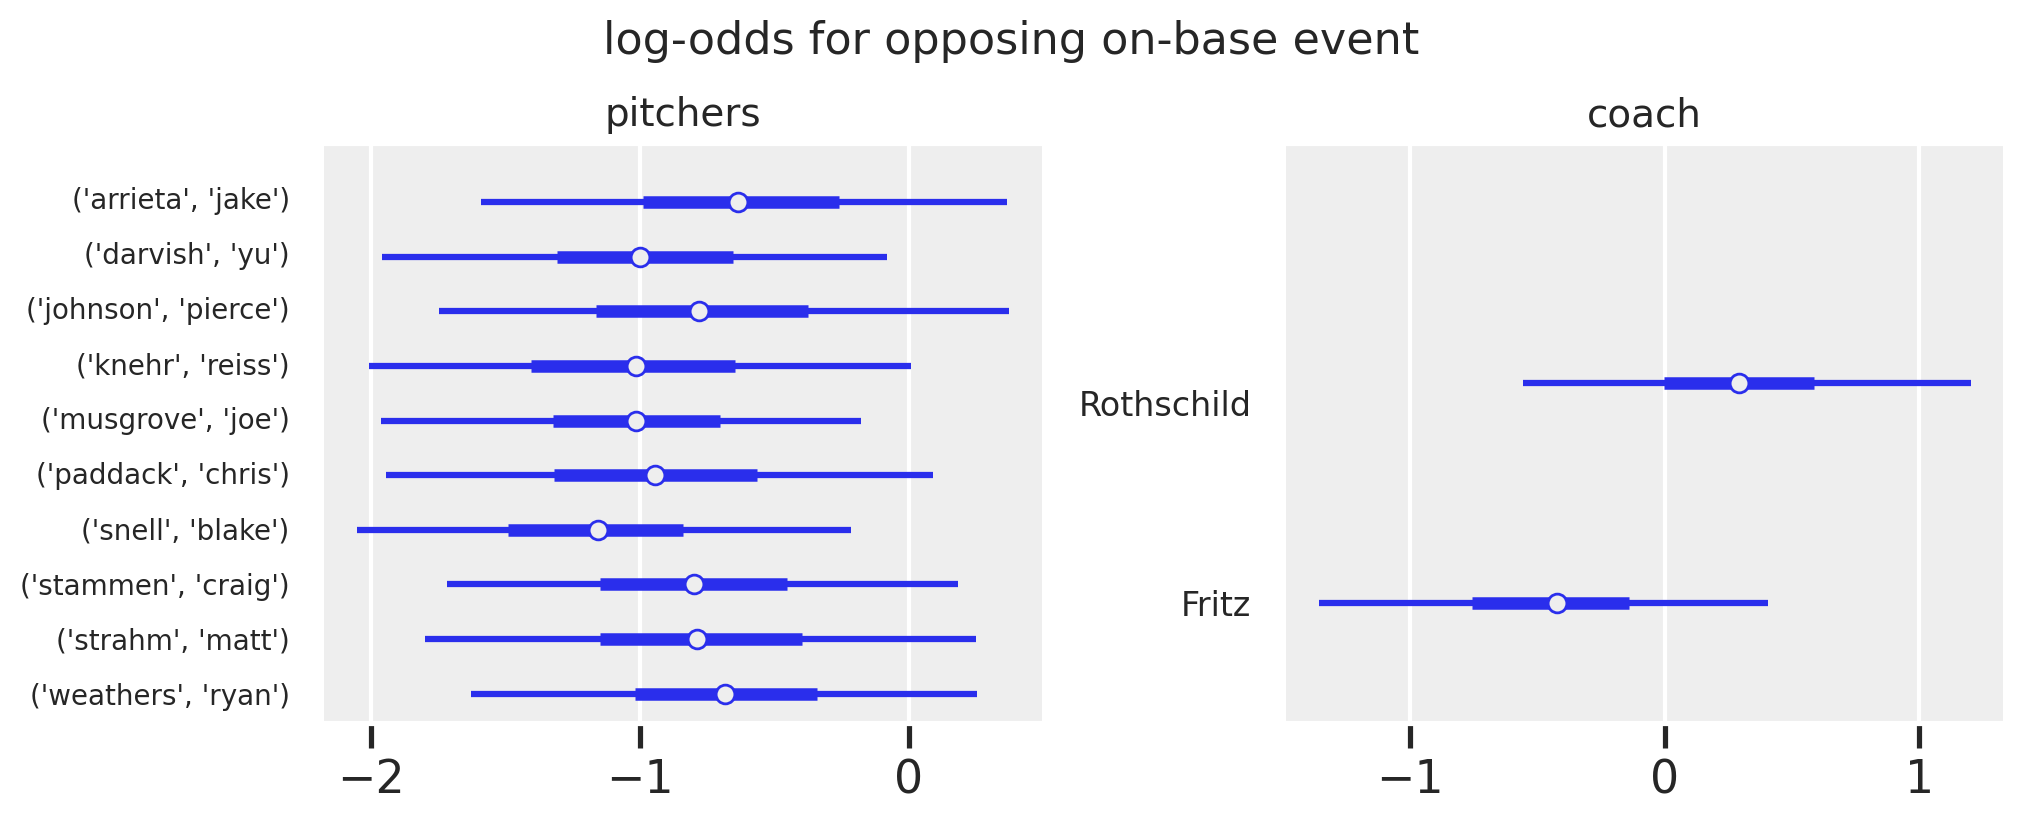

<IPython.core.display.Javascript object>

In [140]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
az.plot_forest(trace_m3, var_names="a", combined=True, ax=ax1)
az.plot_forest(trace_m3, var_names="g", combined=True, ax=ax2)
f.suptitle("log-odds for opposing on-base event", size=16)
ax1.set_title("pitchers", size=14)
ax2.set_title("coach", size=14)
# ax1.set_yticks(range(n_pitcher))  # labels not lining up
ax1.set_yticks(np.linspace(0, 7.5, n_pitcher))
ax1.set_yticklabels(sorted(df_padres["pitcher"].unique())[::-1], fontsize=10)
# ax2.set_yticks(range(n_coach))
ax2.set_yticks([0, 0.75])
ax2.set_yticklabels(["Fritz", "Rothschild"], fontsize=12)

In [172]:
df_summary_pitcher.head()

,mean_x,sd_x,hdi_5.5%_x,hdi_94.5%_x,mean_y,sd_y,hdi_5.5%_y,hdi_94.5%_y,vars
0,0.339,0.691,-0.832,1.408,-0.605,0.616,-1.588,0.364,a[0]
1,-0.419,0.671,-1.541,0.600,-0.967,0.588,-1.956,-0.080,a[1]
2,0.543,0.988,-1.006,2.163,-0.755,0.665,-1.747,0.374,a[2]
3,-1.024,0.919,-2.441,0.424,-1.014,0.646,-2.007,0.010,a[3]
4,-0.434,0.642,-1.559,0.497,-0.997,0.572,-1.963,-0.176,a[4]


<IPython.core.display.Javascript object>

In [ ]:
f, ax1 = plt.subplots()
sns.scatterplot(
    data=df_summary_pitcher, x="sd_x", y="sd_y", size="n_women", color="gray", ax=ax1
)
ax1.plot([0, 1.2], [0, 1.2], color="black", lw=1, linestyle="--")
ax1.set(
    xlim=[0, 1.2], ylim=[0, 1.2], xlabel="fixed effects SD", ylabel="mixed effects SD"
)

## Comparison with chimpanzees code

In [258]:
df_padres

,pitcher,game_date,n_ab,n_ob,obp,pitching_coach,pitcher_code,pitching_coach_code,coach_code
0,"('knehr', 'reiss')",2021-08-01,10,2,0.200000,Rothschild,3,0,0
1,"('snell', 'blake')",2021-08-03,23,9,0.391304,Rothschild,6,0,0
2,"('musgrove', 'joe')",2021-08-04,24,7,0.291667,Rothschild,4,0,0
3,"('arrieta', 'jake')",2021-08-05,19,9,0.473684,Rothschild,0,0,0
4,"('weathers', 'ryan')",2021-08-06,16,8,0.500000,Rothschild,9,0,0
5,"('darvish', 'yu')",2021-08-07,25,4,0.160000,Rothschild,1,0,0
6,"('snell', 'blake')",2021-08-08,26,5,0.192308,Rothschild,6,0,0
7,"('musgrove', 'joe')",2021-08-09,24,6,0.250000,Rothschild,4,0,0
8,"('stammen', 'craig')",2021-08-10,11,6,0.545455,Rothschild,7,0,0
9,"('weathers', 'ryan')",2021-08-11,21,8,0.380952,Rothschild,9,0,0


<IPython.core.display.Javascript object>

In [252]:
# Looked at repo code for R 13.29
with pm.Model() as m3:

    a_bar = pm.Normal("a_bar", 0, 1.5)
    #     sigma_a = pm.HalfNormal("sigma_a", sigma=1)
    #     sigma_g = pm.HalfNormal("sigma_g", sigma=1)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    sigma_g = pm.Exponential("sigma_g", 1.0)

    z = pm.Normal("z", 0, 1, shape=n_pitcher)
    x = pm.Normal("x", 0, 1, shape=n_coach)

    # non-centered version, but not being used
    _ = pm.Deterministic("a", a_bar + z * sigma_a)
    _ = pm.Deterministic("g", x * sigma_g)

    # linear model
    p = pm.math.invlogit(
        a_bar
        + z[df_padres["pitcher_code"]] * sigma_a
        + x[df_padres["coach_code"]] * sigma_g
    )

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample
    trace_m3 = pm.sample(
        draws=1000,
        random_seed=19,
        tune=2000,
        target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, z, sigma_g, sigma_a, a_bar]
INFO:pymc3:NUTS: [x, z, sigma_g, sigma_a, a_bar]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 32 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 32 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


<IPython.core.display.Javascript object>

In [253]:
# Looked at repo code for R 13.29
with pm.Model() as m3a:

    a_bar = pm.Normal("a_bar", 0, 1.5)
    #     sigma_a = pm.HalfNormal("sigma_a", sigma=1)
    #     sigma_g = pm.HalfNormal("sigma_g", sigma=1)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    # sigma_g = pm.Exponential("sigma_g", 1.0)

    z = pm.Normal("z", 0, 1, shape=n_pitcher)
    # x = pm.Normal("x", 0, 1, shape=n_coach)

    # non-centered version, but not being used
    _ = pm.Deterministic("a", a_bar + z * sigma_a)
    # _ = pm.Deterministic("g", x * sigma_g)

    # linear model
    p = pm.math.invlogit(a_bar + z[df_padres["pitcher_code"]] * sigma_a)

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample
    trace_m3a = pm.sample(
        draws=1000,
        random_seed=19,
        tune=2000,
        target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, sigma_a, a_bar]
INFO:pymc3:NUTS: [z, sigma_a, a_bar]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 19 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 19 seconds.


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

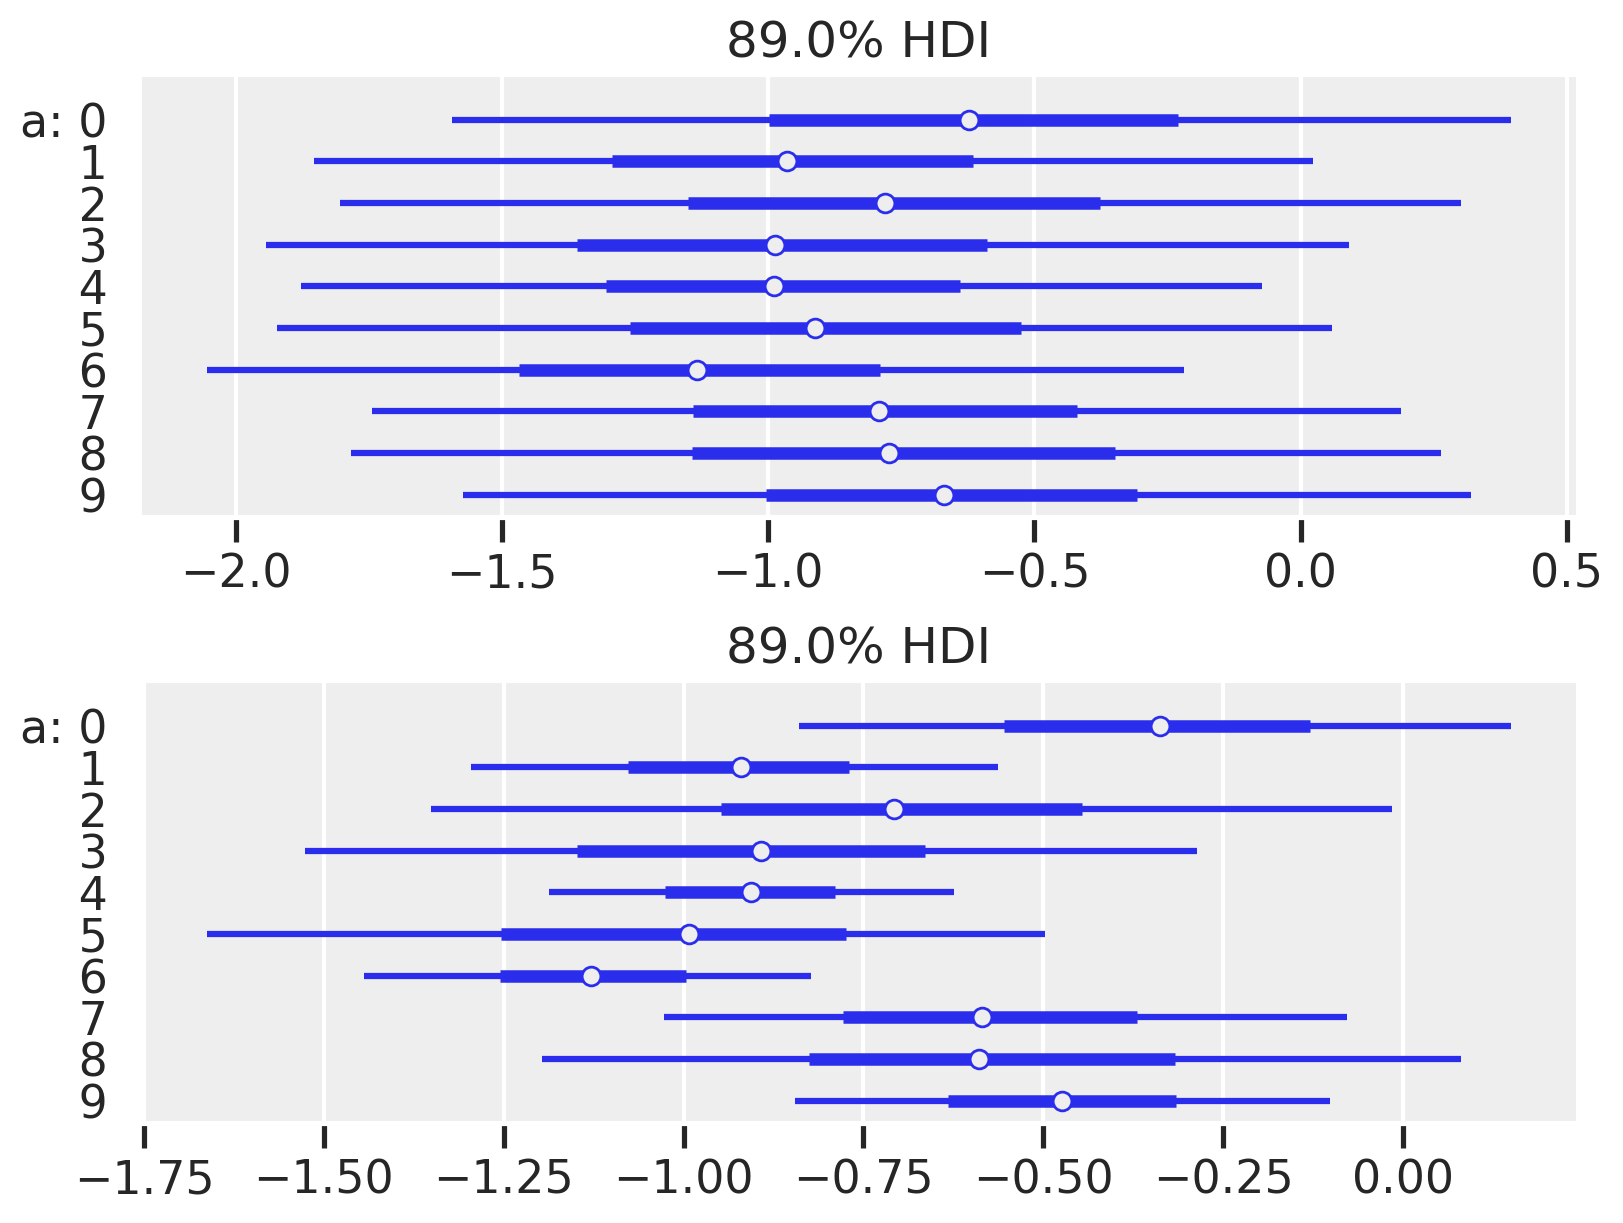

<IPython.core.display.Javascript object>

In [255]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
az.plot_forest(trace_m3, var_names="a", combined=True, ax=ax1)
az.plot_forest(trace_m3a, var_names="a", combined=True, ax=ax2)

In [ ]:
with pm.Model() as m_13_4nca:
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    sigma_g = pm.Exponential("sigma_g", 1.0)

    z = pm.Normal("z", 0.0, 1.0, shape=Nactor)
    x = pm.Normal("x", 0.0, 1.0, shape=Nblock)

    _ = pm.Deterministic("a", a_bar + z * sigma_a)  # actor intercepts
    _ = pm.Deterministic("g", x * sigma_g)  # block intercepts
    p = pm.math.invlogit(a_bar + z[actor] * sigma_a + x[block] * sigma_g)
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    trace_13_4nca = pm.sample(tune=3000, target_accept=0.9, random_seed=RANDOM_SEED)
    #idata_13_4nca = az.from_pymc3(trace_13_4nc)

# NEXT STEPS: double check equation and model parameters for pitcher and coach models

# OLD CODE BELOW THIS ---- 

In [25]:
with pm.Model() as m2:

    # regularizing prior for average picher
    a_bar = pm.Normal("a_bar", 0, 3)

    # prior for SD of pitchers
    sigma = pm.Exponential("sigma", 1)

    # addaptive prior learns across pitchers
    a = pm.Normal("a", a_bar, sigma, shape=n_pitcher)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample
    trace_m2 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7115425727322958, but should be close to 0.8. Try to increase the number of tuning steps.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6479714704882196, but should be close to 0.8. Try to increase the number of tuning steps.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6161142151956649, but should be close to 0.8. Try to increase the number of tuning steps.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

The warnings indicate divergent transitions. Let's look at the trace plots.

## Model diagnostics

array([[<AxesSubplot:title={'center':'a_bar'}>,
        <AxesSubplot:title={'center':'a_bar'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

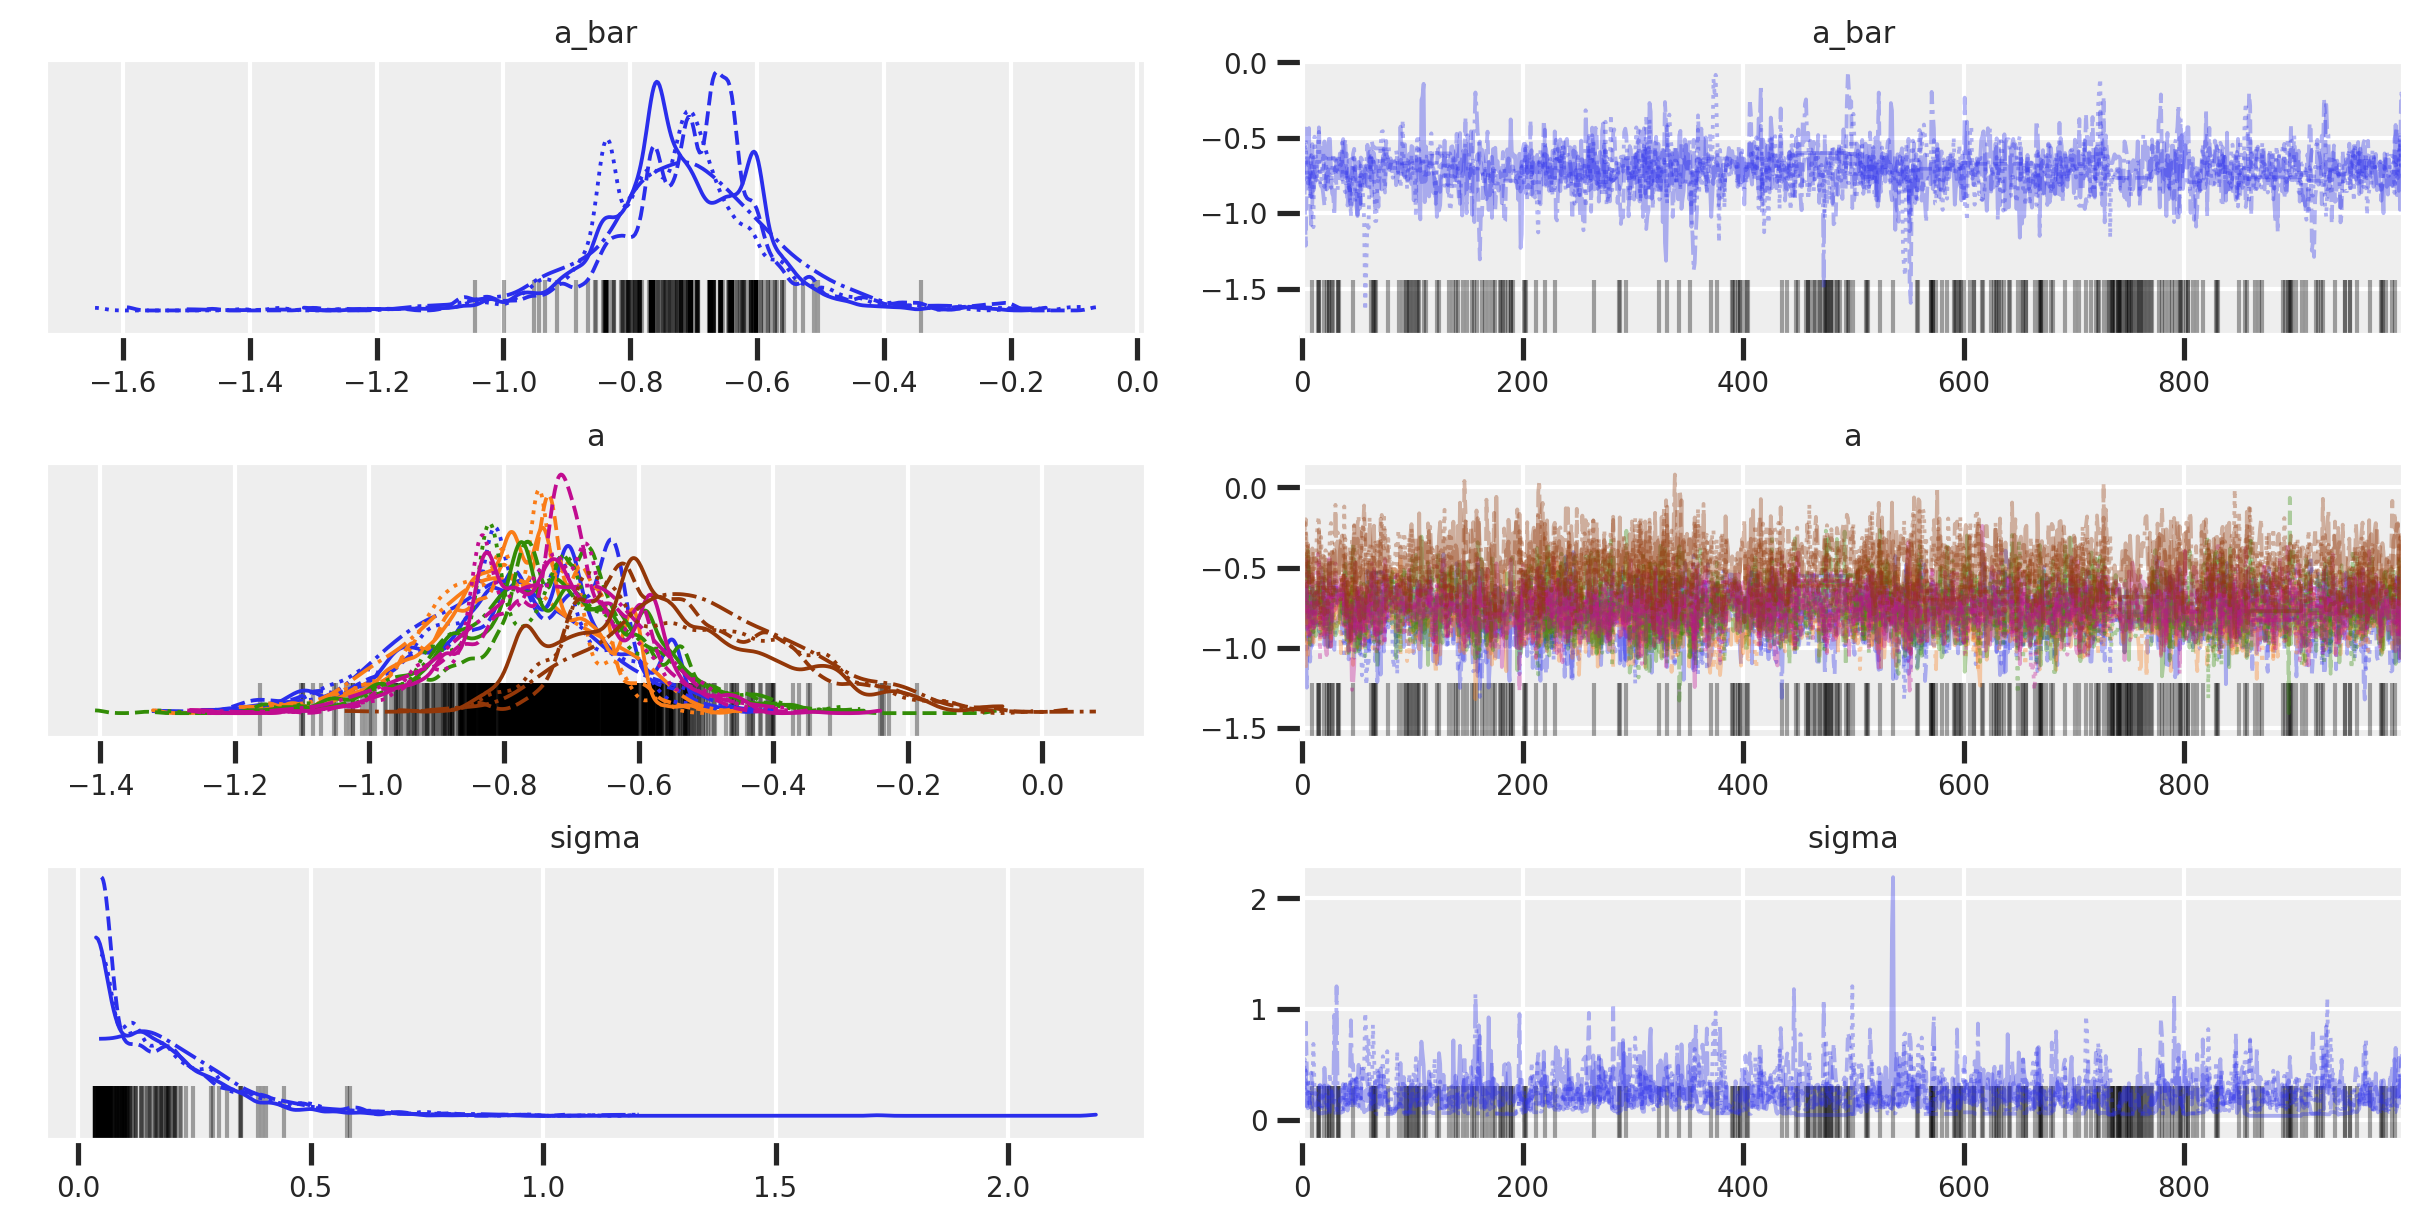

<IPython.core.display.Javascript object>

In [27]:
az.plot_trace(trace_m2)

In [65]:
az.summary(trace_m2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.716,0.138,-0.918,-0.511,0.004,0.003,1278.0,1278.0,1051.0,1854.0,1.01
a[0],-0.793,0.141,-0.995,-0.551,0.006,0.004,539.0,539.0,512.0,301.0,1.01
a[1],-0.794,0.116,-0.970,-0.605,0.005,0.004,516.0,516.0,482.0,251.0,1.01
a[2],-0.732,0.142,-0.969,-0.517,0.004,0.003,1452.0,1452.0,1369.0,2219.0,1.01
a[3],-0.734,0.124,-0.936,-0.550,0.004,0.003,1006.0,1006.0,985.0,1708.0,1.01
a[4],-0.529,0.158,-0.772,-0.291,0.009,0.007,336.0,274.0,289.0,185.0,1.01
sigma,0.210,0.162,0.036,0.394,0.009,0.006,343.0,343.0,136.0,106.0,1.02


<IPython.core.display.Javascript object>

Should I re-parameterize? The book indicates that changing `adapt_delta` (in Stan) would be a way to fix this. In pymc, I can increase the tuning.

In [29]:
with pm.Model() as m2:

    # regularizing prior for average picher
    a_bar = pm.Normal("a_bar", 0, 3)

    # prior for SD of pitchers
    sigma = pm.Exponential("sigma", 1)

    # addaptive prior learns across pitchers
    a = pm.Normal("a", a_bar, sigma, shape=n_pitcher)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample - increased tune 
    # like warmup https://colcarroll.github.io/hmc_tuning_talk/
    trace_m2 = pm.sample(
        draws=1000, random_seed=19, tune=3000, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 24 seconds.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6994494642401462, but should be close to 0.8. Try to increase the number of tuning steps.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>

In [30]:
az.summary(trace_m2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.713,0.156,-0.904,-0.482,0.005,0.003,1017.0,1017.0,1343.0,1516.0,1.01
a[0],-0.801,0.139,-1.023,-0.583,0.004,0.003,1046.0,1046.0,1040.0,1183.0,1.00
a[1],-0.806,0.122,-1.009,-0.620,0.003,0.002,1334.0,1334.0,1313.0,790.0,1.00
a[2],-0.731,0.147,-0.963,-0.492,0.003,0.002,1922.0,1922.0,1814.0,2487.0,1.00
a[3],-0.733,0.126,-0.926,-0.528,0.003,0.002,2167.0,2144.0,2111.0,2573.0,1.00
a[4],-0.509,0.158,-0.762,-0.265,0.006,0.004,727.0,638.0,691.0,734.0,1.00
sigma,0.237,0.182,0.041,0.419,0.007,0.005,693.0,693.0,377.0,267.0,1.00


<IPython.core.display.Javascript object>

Better but still not great. Initially, I thought about re-paramaterizing and using a non-centered form. But in McElreath's text (page 407-408) he talks about some issues with using exponential priors, particularly when the number of clusters is not very high. (By coincidence, the example he used was "5 clusters" which is the same in this problem.) This number of clusters is like using 5 data points and it can make extreme values plausible for the model.

## Model with half-normal for sigma

**Model `m3` equation**

$ O_i \sim \text{Binomial}(n_i, p_i) \tag{O for number of on-base events} $

$ \text{logit}(p_i) = \alpha_{\text{PITCHER}[i]} \tag{pitcher is encoded as an index variable} $

$ \alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior} $

$ \bar{\alpha} \sim \text{Normal}(0, 1.5) \tag{prior for average pitcher} $

$ \sigma \sim \text{Half-Normal}(0, 1) \tag{prior for SD of pitchers} $

In [41]:
df_padres

,pitcher,game_date,n_ab,n_ob,obp,pitching_coach,pitcher_code,pitching_coach_code
0,"('weathers', 'ryan')",2021-07-01,20,9,0.450000,Rothschild,4,0
1,"('paddack', 'chris')",2021-07-02,26,5,0.192308,Rothschild,2,0
2,"('darvish', 'yu')",2021-07-03,25,7,0.280000,Rothschild,0,0
3,"('snell', 'blake')",2021-07-04,17,7,0.411765,Rothschild,3,0
4,"('musgrove', 'joe')",2021-07-05,24,8,0.333333,Rothschild,1,0
5,"('weathers', 'ryan')",2021-07-06,21,7,0.333333,Rothschild,4,0
6,"('paddack', 'chris')",2021-07-07,17,10,0.588235,Rothschild,2,0
7,"('darvish', 'yu')",2021-07-08,17,8,0.470588,Rothschild,0,0
8,"('musgrove', 'joe')",2021-07-10,21,7,0.333333,Rothschild,1,0
9,"('weathers', 'ryan')",2021-07-11,9,3,0.333333,Rothschild,4,0


<IPython.core.display.Javascript object>

In [112]:
df_padres.groupby("pitcher").sum()["n_ab"]

pitcher
('darvish', 'yu')       176
('musgrove', 'joe')     249
('paddack', 'chris')    118
('snell', 'blake')      199
('weathers', 'ryan')    167
Name: n_ab, dtype: int64

<IPython.core.display.Javascript object>

In [40]:
with pm.Model() as m3:

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 1)

    # prior for SD of pitchers
    sigma = pm.HalfNormal("sigma", sigma=0.25)

    # addaptive prior learns across pitchers
    a = pm.Normal("a", a_bar, sigma, shape=n_pitcher)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample - increased tune
    # like warmup https://colcarroll.github.io/hmc_tuning_talk/
    trace_m3 = pm.sample(
        draws=1000, random_seed=19, tune=3000, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
INFO:pymc3:NUTS: [a, sigma, a_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 16 seconds.
INFO:pymc3:Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 16 seconds.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.652622552462576, but should be close to 0.8. Try to increase the number of tuning steps.
There were 252 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 252 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.49871490369005406, but should be close to 0.8. Try to increase the number of tuning steps.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 53 d

<IPython.core.display.Javascript object>

In [38]:
with pm.Model() as m4:

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 1.5)

    # prior for SD of pitchers
    sigma = pm.Lognormal("sigma", 0, 1)

    # addaptive prior learns across pitchers
    a = pm.Normal("a", a_bar, sigma, shape=n_pitcher)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample - increased tune
    # like warmup https://colcarroll.github.io/hmc_tuning_talk/
    trace_m4 = pm.sample(
        draws=1000, random_seed=19, tune=3000, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
INFO:pymc3:NUTS: [a, sigma, a_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 20 seconds.
INFO:pymc3:Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 20 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some 

<IPython.core.display.Javascript object>

In [42]:
with pm.Model() as m5:

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 0.5)

    # prior for SD of pitchers
    sigma = pm.HalfNormal("sigma", sigma=0.5)

    # addaptive prior learns across pitchers
    a = pm.Normal("a", a_bar, sigma, shape=n_pitcher)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample - increased tune
    # like warmup https://colcarroll.github.io/hmc_tuning_talk/
    trace_m5 = pm.sample(
        draws=1000, random_seed=19, tune=3000, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
INFO:pymc3:NUTS: [a, sigma, a_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 23 seconds.
INFO:pymc3:Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 23 seconds.
There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 122 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6375039960089248, but should be close to 0.8. Try to increase the number of tuning steps.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6981058180061871, but s

<IPython.core.display.Javascript object>

In [89]:
# even narrower
with pm.Model() as m5:

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 0.25)

    # prior for SD of pitchers
    sigma = pm.HalfNormal("sigma", sigma=0.25)

    # addaptive prior learns across pitchers
    a = pm.Normal("a", a_bar, sigma, shape=n_pitcher)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample - increased target accept (0.95 is already high)
    trace_m5 = pm.sample(
        draws=1000,
        random_seed=19,
        tune=3000,
        return_inferencedata=True,
        target_accept=0.99,
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
INFO:pymc3:NUTS: [a, sigma, a_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 37 seconds.
INFO:pymc3:Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 37 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

Text(0.5, 0, 'log-odds')

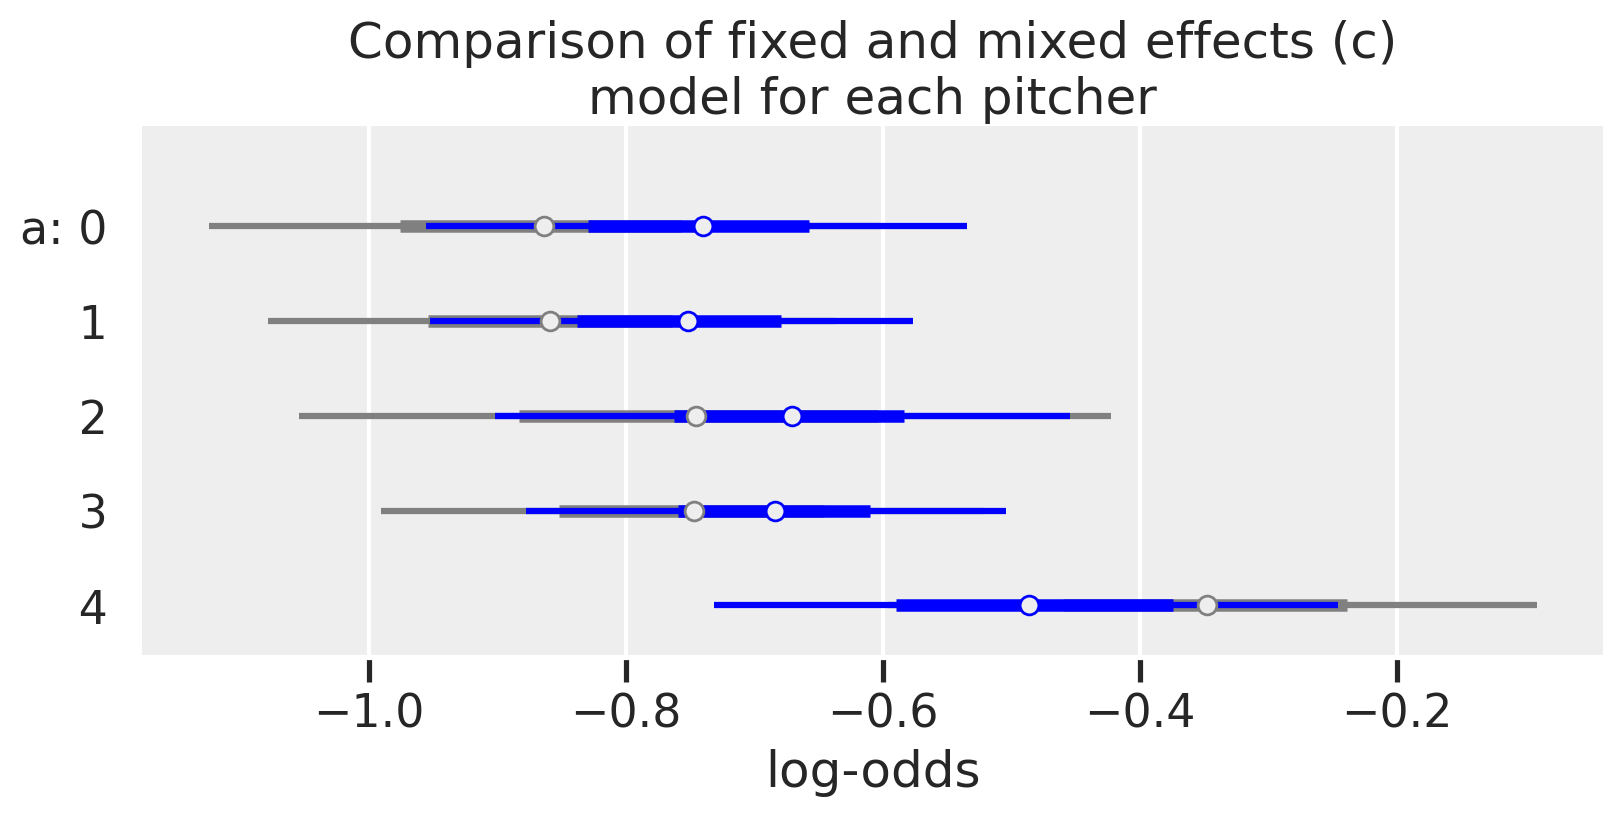

<IPython.core.display.Javascript object>

In [100]:
f, (ax1) = plt.subplots(1, 1, figsize=(8, 4), sharex=True)

az.plot_forest(trace_m1, var_names="a", combined=True, ax=ax1, colors="gray")
az.plot_forest(
    trace_m5,
    var_names="a",
    combined=True,
    colors="blue",
    ax=ax1,
)
ax1.set_title("Comparison of fixed and mixed effects (c)\nmodel for each pitcher")
ax1.set_xlabel("log-odds")

In [46]:
# going back to exponential (from Jan Christian)
with pm.Model() as m6:

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 0.5)

    # prior for SD of pitchers
    sigma = pm.Exponential("sigma", 0.5)

    # addaptive prior learns across pitchers
    a = pm.Normal("a", a_bar, sigma, shape=n_pitcher)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    trace_m6 = pm.sample(
        draws=1000,
        random_seed=19,
        tune=3000,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]
INFO:pymc3:NUTS: [a, sigma, a_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 22 seconds.
INFO:pymc3:Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 22 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for som

<IPython.core.display.Javascript object>

Jan Christian suggested putting a beta prior on p. It led to me finding [this page](https://docs.pymc.io/notebooks/GLM-hierarchical-binominal-model.html) where I took some code.

In [45]:
def logp_ab(value):
    """ prior density, weakly informative prior"""
    return tt.log(tt.pow(tt.sum(value), -5 / 2))

<IPython.core.display.Javascript object>

In [49]:
n_pitcher

5

<IPython.core.display.Javascript object>

In [52]:
# beta prior on pi
# followed thisa
with pm.Model() as m8:

    # linear model
    p = pm.Beta("p", 1, 1)

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample - increased tune
    # like warmup https://colcarroll.github.io/hmc_tuning_talk/
    trace_m8 = pm.sample(
        draws=1000, random_seed=19, tune=2000, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
INFO:pymc3:NUTS: [p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.


<IPython.core.display.Javascript object>

# Non-centered?

In [ ]:
# even narrower
with pm.Model() as m5:
    
    z = pm.Normal("z", 0, 1, shape=n_pitcher)

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 0.25)

    # prior for SD of pitchers
    sigma = pm.HalfNormal("sigma", sigma=0.25)

    # addaptive prior learns across pitchers
    a = pm.Normal("a", a_bar, sigma, shape=n_pitcher)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample - increased target accept (0.95 is already high)
    trace_m5 = pm.sample(
        draws=1000,
        random_seed=19,
        tune=3000,
        return_inferencedata=True,
        target_accept=0.99,
    )

## Re-paramaterized model

In [63]:
with pm.Model() as m9:

    # z is a variable to transform within the linear model
    z = pm.Normal("z", 0, 1, shape=n_pitcher)

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 1.5)

    # prior for SD of pitchers
    sigma = pm.HalfNormal("sigma", sigma=1)

    # adaptive prior learns across pitchers
    # this is the variable that's transformed
    # instead of substituting, we'll use this in linear model
    # a = pm.Normal("a", a_bar, sigma, shape=n_pitcher)   # centered version
    a = pm.Deterministic("a", a_bar + z * sigma)  # non-centered version

    # linear model
    p = pm.math.invlogit(a_bar + a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample
    trace_m9 = pm.sample(
        draws=1000,
        random_seed=19,
        tune=1000,
        target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a_bar, z]
INFO:pymc3:NUTS: [sigma, a_bar, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [64]:
az.summary(trace_m9)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
z[0],-0.369,0.768,-1.588,0.893,0.018,0.013,1918.0,1805.0,1910.0,2208.0,1.0
z[1],-0.412,0.741,-1.561,0.737,0.018,0.012,1760.0,1760.0,1739.0,2086.0,1.0
z[2],-0.087,0.778,-1.336,1.153,0.017,0.014,2222.0,1644.0,2180.0,2408.0,1.0
z[3],-0.100,0.750,-1.222,1.120,0.018,0.014,1760.0,1512.0,1748.0,2118.0,1.0
z[4],0.875,0.802,-0.309,2.161,0.020,0.014,1600.0,1600.0,1624.0,2202.0,1.0
a_bar,-0.357,0.072,-0.461,-0.251,0.003,0.002,684.0,654.0,843.0,763.0,1.0
sigma,0.233,0.197,0.001,0.441,0.009,0.006,508.0,484.0,573.0,765.0,1.0
a[0],-0.442,0.140,-0.655,-0.228,0.003,0.002,1623.0,1589.0,1693.0,2176.0,1.0
a[1],-0.447,0.126,-0.636,-0.247,0.003,0.002,1769.0,1764.0,1811.0,2475.0,1.0
a[2],-0.377,0.144,-0.603,-0.141,0.003,0.002,2167.0,2162.0,2306.0,2124.0,1.0


<IPython.core.display.Javascript object>

### Comparison of fixed-effects and mixed-effects models

Text(0.5, 0, 'log-odds')

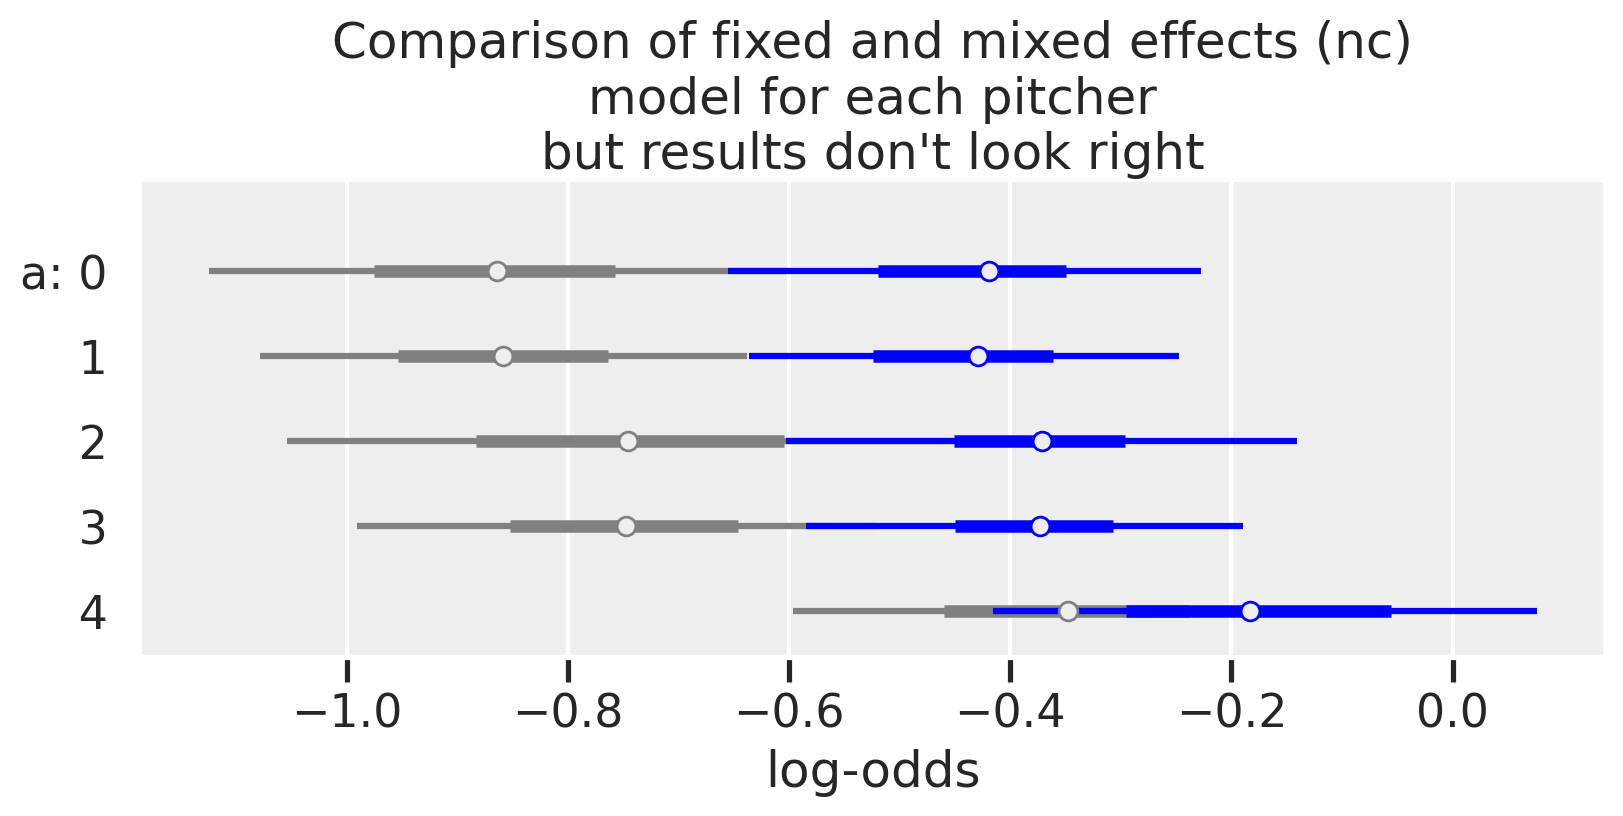

<IPython.core.display.Javascript object>

In [104]:
f, (ax1) = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
# f.suptitle("Comparison of fixed and mixed effects model for each pitcher")

# For plotting decoration
kwg = {"label": "mixed"}
az.plot_forest(trace_m1, var_names="a", combined=True, ax=ax1, colors="gray")
az.plot_forest(
    trace_m9,
    var_names="a",
    combined=True,
    ax=ax1,
    colors="blue",
    backend="matplotlib",
    backend_kwargs=kwg,
)
ax1.legend()
ax1.set_title(
    "Comparison of fixed and mixed effects (nc)\nmodel for each pitcher\nbut results don't look right"
)
ax1.set_xlabel("log-odds")

In [107]:
with pm.Model() as m9a:

    # z is a variable to transform within the linear model
    z = pm.Normal("z", 0, 1, shape=n_pitcher)

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 1.5)

    # prior for SD of pitchers
    sigma = pm.HalfNormal("sigma", sigma=1)

    # moved df_padres["pitcher_code"] to here
    a = pm.Deterministic(
        "a", a_bar + z[df_padres["pitcher_code"]] * sigma
    )  # non-centered version

    # linear model
    p = pm.math.invlogit(a_bar + a)

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample
    trace_m9a = pm.sample(
        draws=1000,
        random_seed=19,
        tune=1000,
        target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a_bar, z]
INFO:pymc3:NUTS: [sigma, a_bar, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [109]:
az.summary(trace_m9a)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
z[0],-0.356,0.764,-1.518,0.880,0.016,0.013,2301.0,1797.0,2285.0,2464.0,1.00
z[1],-0.416,0.752,-1.620,0.740,0.017,0.012,1950.0,1843.0,1928.0,2458.0,1.00
z[2],-0.071,0.775,-1.332,1.107,0.015,0.013,2717.0,1754.0,2679.0,2654.0,1.00
z[3],-0.082,0.728,-1.200,1.114,0.016,0.013,2093.0,1650.0,2071.0,2453.0,1.00
z[4],0.912,0.792,-0.352,2.150,0.018,0.013,1841.0,1841.0,1828.0,2121.0,1.00
a_bar,-0.356,0.071,-0.475,-0.256,0.002,0.001,1171.0,1171.0,1242.0,1052.0,1.00
sigma,0.232,0.175,0.000,0.442,0.006,0.005,737.0,737.0,683.0,957.0,1.01
a[0],-0.161,0.162,-0.417,0.068,0.004,0.003,1496.0,1399.0,1402.0,2525.0,1.01
a[1],-0.376,0.144,-0.608,-0.158,0.002,0.002,3325.0,3208.0,3369.0,3191.0,1.00
a[2],-0.444,0.140,-0.662,-0.232,0.003,0.002,2181.0,2046.0,2238.0,2393.0,1.00


<IPython.core.display.Javascript object>

Text(0.5, 0, 'log-odds')

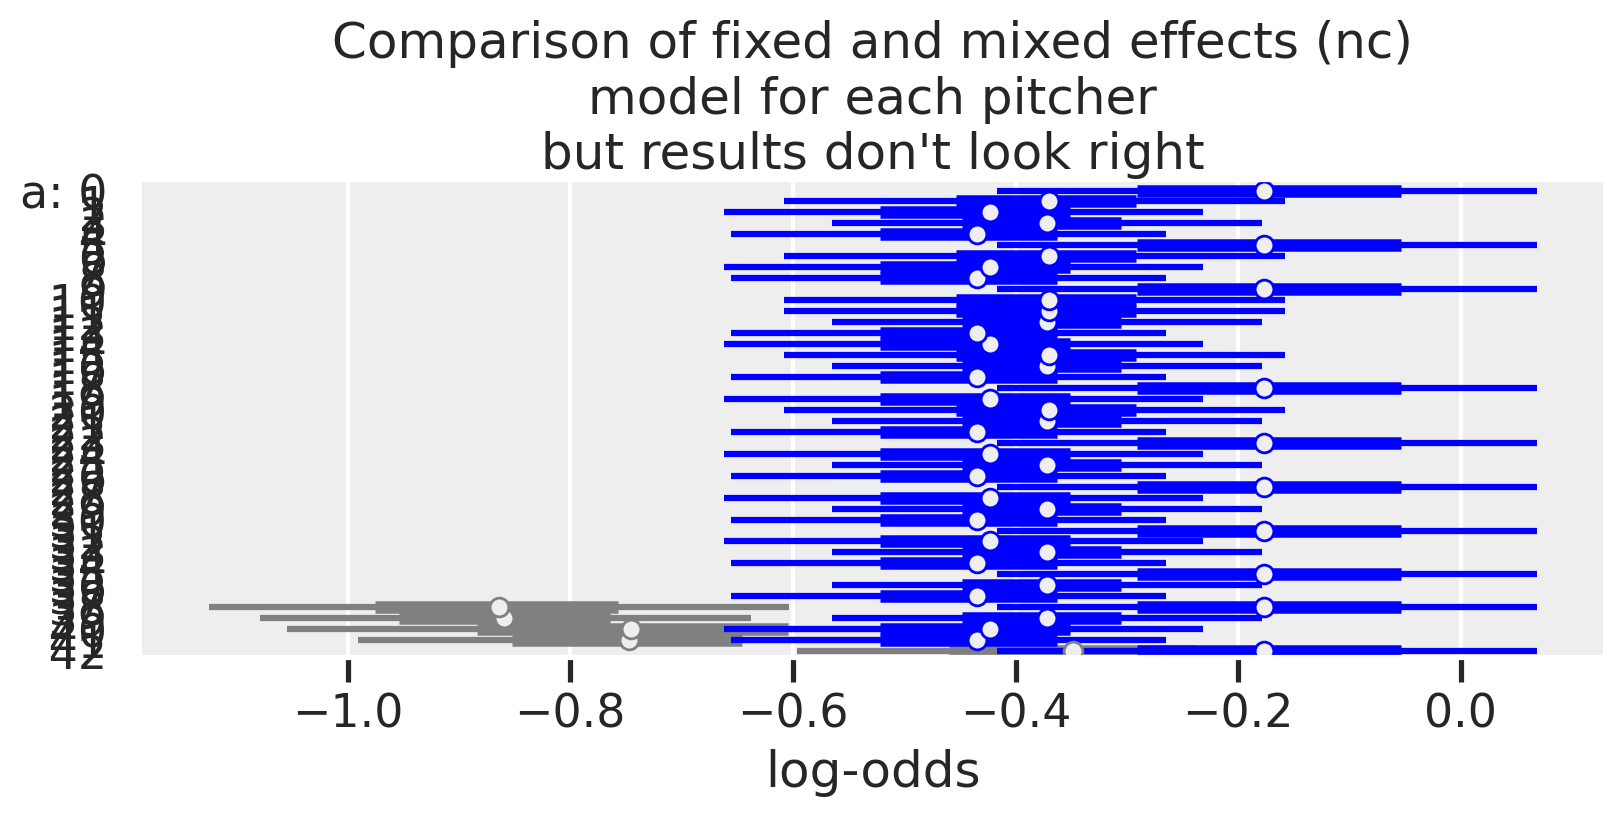

<IPython.core.display.Javascript object>

In [108]:
f, (ax1) = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
# f.suptitle("Comparison of fixed and mixed effects model for each pitcher")

az.plot_forest(trace_m1, var_names="a", combined=True, ax=ax1, colors="gray")
az.plot_forest(
    trace_m9a,
    var_names="a",
    combined=True,
    ax=ax1,
    colors="blue",
    backend="matplotlib",
    backend_kwargs=kwg,
)
ax1.legend()
ax1.set_title(
    "Comparison of fixed and mixed effects (nc)\nmodel for each pitcher\nbut results don't look right"
)
ax1.set_xlabel("log-odds")

## Other tests of re-paramaterized model

In [ ]:
with pm.Model() as m9:

    # z is a variable to transform within the linear model
    z = pm.Normal("z", 0, 1, shape=n_pitcher)

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 1.5)

    # prior for SD of pitchers
    sigma = pm.HalfNormal("sigma", sigma=1)

    # adaptive prior learns across pitchers
    # this is the variable that's transformed
    # instead of substituting, we'll use this in linear model
    # a = pm.Normal("a", a_bar, sigma, shape=n_pitcher)   # centered version
    a = pm.Deterministic("a", a_bar + z * sigma)  # non-centered version

    # linear model
    p = pm.math.invlogit(a_bar + a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample
    trace_m9 = pm.sample(
        draws=1000,
        random_seed=19,
        tune=1000,
        target_accept=0.95,
        return_inferencedata=True,
    )

In [101]:
# Looked at repo code for R 13.29
with pm.Model() as m10:

    a_bar = pm.Normal("a_bar", 0, 1.5)
    sigma = pm.HalfNormal("sigma", sigma=1)
    z = pm.Normal("z", 0, 1, shape=n_pitcher)

    _ = pm.Deterministic(
        "a", a_bar + z * sigma
    )  # non-centered version, but not being used

    # linear model
    p = pm.math.invlogit(a_bar + z[df_padres["pitcher_code"]] * sigma)

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample
    trace_m10 = pm.sample(
        draws=1000,
        random_seed=19,
        tune=2000,
        target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, sigma, a_bar]
INFO:pymc3:NUTS: [z, sigma, a_bar]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 20 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [103]:
az.summary(trace_m10)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.708,0.139,-0.914,-0.499,0.005,0.004,736.0,736.0,858.0,785.0,1.01
z[0],-0.415,0.757,-1.643,0.749,0.018,0.012,1841.0,1841.0,1803.0,1923.0,1.00
z[1],-0.418,0.741,-1.542,0.756,0.018,0.013,1610.0,1610.0,1596.0,2399.0,1.00
z[2],-0.076,0.780,-1.276,1.211,0.017,0.013,2154.0,1747.0,2131.0,2485.0,1.00
z[3],-0.104,0.758,-1.302,1.107,0.015,0.012,2420.0,1966.0,2418.0,2582.0,1.00
z[4],0.857,0.808,-0.357,2.174,0.020,0.014,1712.0,1699.0,1688.0,1890.0,1.00
sigma,0.227,0.178,0.001,0.424,0.007,0.005,631.0,631.0,652.0,923.0,1.01
a[0],-0.801,0.132,-1.007,-0.594,0.002,0.002,2987.0,2987.0,2913.0,3574.0,1.00
a[1],-0.802,0.120,-0.971,-0.586,0.002,0.002,2924.0,2924.0,2870.0,3634.0,1.00
a[2],-0.732,0.147,-0.955,-0.493,0.003,0.002,3449.0,3292.0,3579.0,2655.0,1.00


<IPython.core.display.Javascript object>

Text(0.5, 0, 'log-odds')

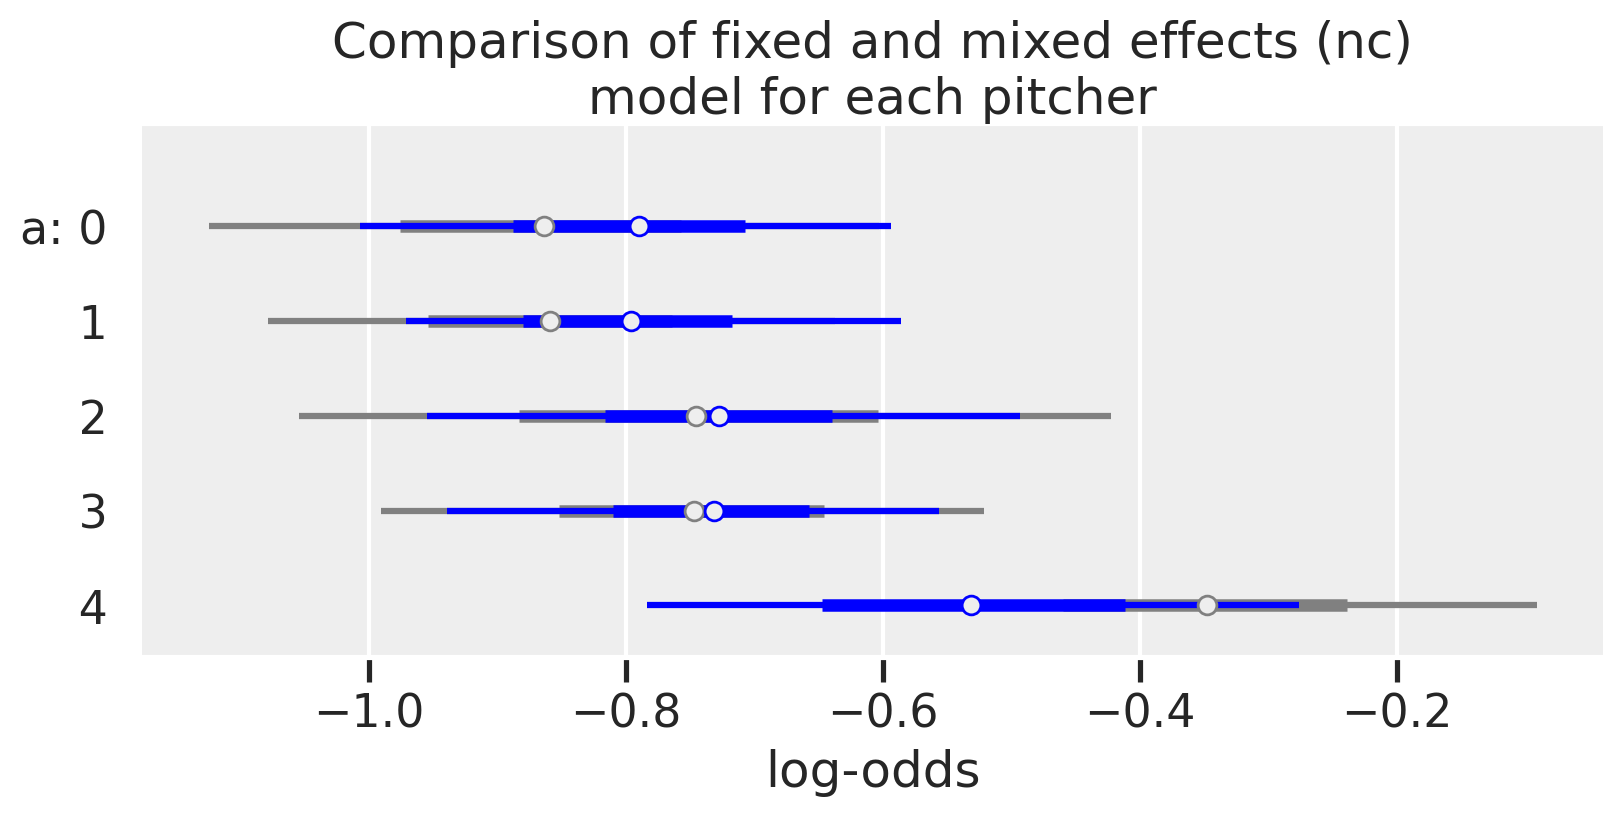

<IPython.core.display.Javascript object>

In [102]:
f, (ax1) = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
# f.suptitle("Comparison of fixed and mixed effects model for each pitcher")

# For plotting decoration
kwg = {"label": "mixed"}
az.plot_forest(trace_m1, var_names="a", combined=True, ax=ax1, colors="gray")
az.plot_forest(
    trace_m10,
    var_names="a",
    combined=True,
    ax=ax1,
    colors="blue",
    backend="matplotlib",
    backend_kwargs=kwg,
)
ax1.legend()
ax1.set_title("Comparison of fixed and mixed effects (nc)\nmodel for each pitcher")
ax1.set_xlabel("log-odds")

Text(0.5, 0, 'log-odds')

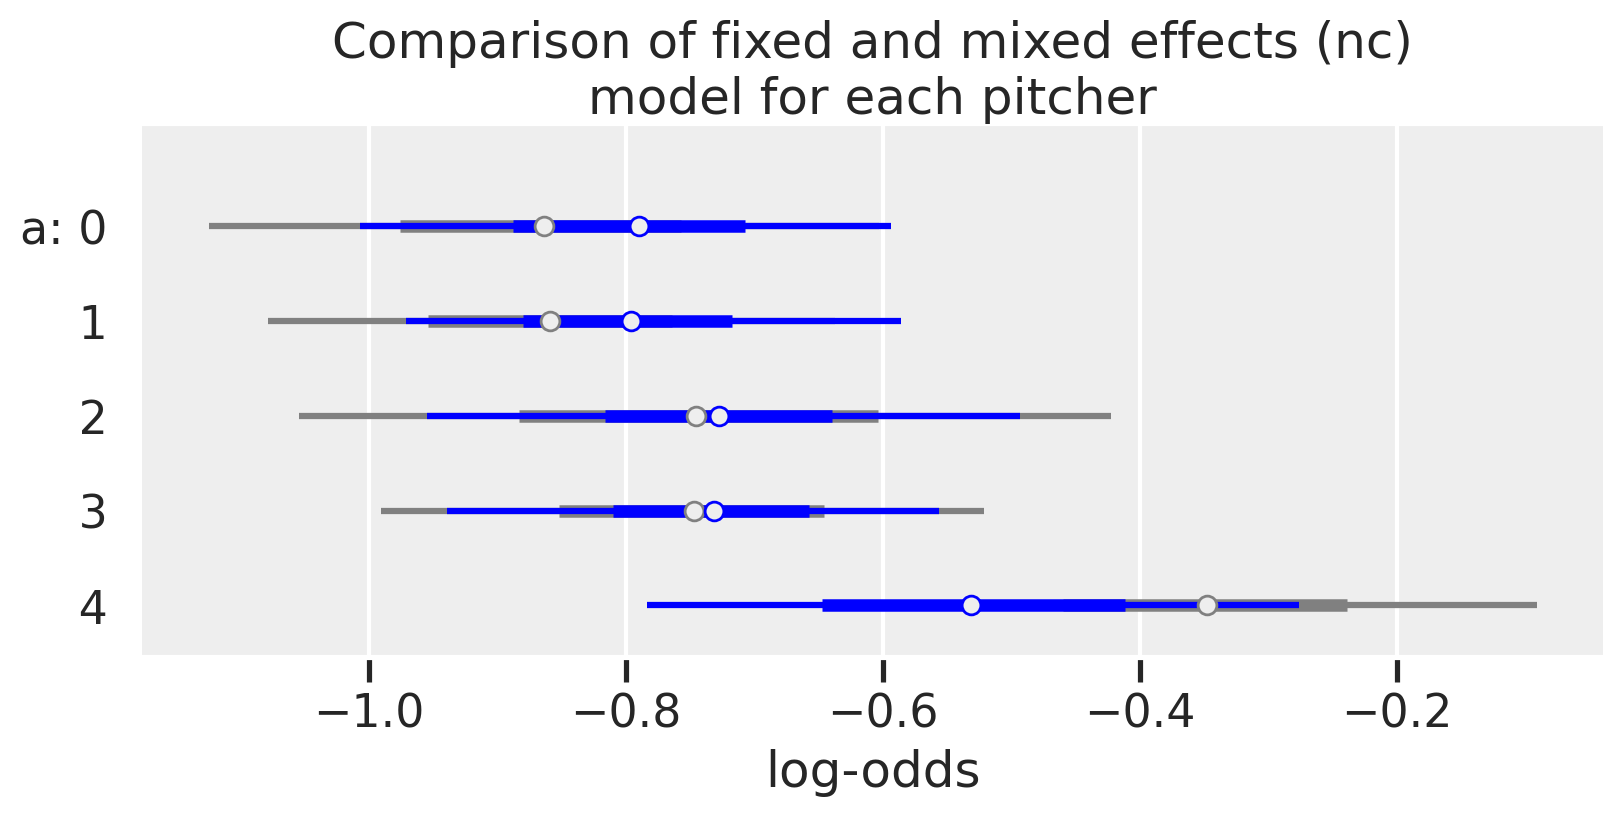

<IPython.core.display.Javascript object>

In [105]:
f, (ax1) = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
# f.suptitle("Comparison of fixed and mixed effects model for each pitcher")

# For plotting decoration
kwg = {"label": "mixed"}
az.plot_forest(trace_m1, var_names="a", combined=True, ax=ax1, colors="gray")
az.plot_forest(
    trace_m10,
    var_names="a",
    combined=True,
    ax=ax1,
    colors="blue",
    backend="matplotlib",
    backend_kwargs=kwg,
)
ax1.legend()
ax1.set_title("Comparison of fixed and mixed effects (nc)\nmodel for each pitcher")
ax1.set_xlabel("log-odds")

In [61]:
# Looked at repo code for R 13.29
with pm.Model() as m11:

    a_bar = pm.Normal("a_bar", 0, 1.5)
    sigma = pm.Exponential("sigma", 1)
    z = pm.Normal("z", 0, 1, shape=n_pitcher)

    _ = pm.Deterministic(
        "a", a_bar + z * sigma
    )  # non-centered version, but not being used

    # linear model
    p = pm.math.invlogit(a_bar + z[df_padres["pitcher_code"]] * sigma)

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample
    trace_m11 = pm.sample(
        draws=1000,
        random_seed=19,
        tune=2000,
        target_accept=0.95,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, sigma, a_bar]
INFO:pymc3:NUTS: [z, sigma, a_bar]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 18 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 18 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

Thank you Jan ... I initially found this intimidating but think got something working. It took quite a few steps but it started to make sense after re-reading section 13.4.

Here is what I did, starting from the centered version of the model (what I had shown above). I'm using`pymc` for context. This might be TMI but maybe it's helpful for someone to see what I tried.

a. Used a Half-Normal prior for sigma based on McElreath's Overthinking box at bottom of page 407. Result: Divergences.
b. Increased `tune` to 2000 from default of 1000. (Tune is analogous to warm-up). Result: Divergences.
c. Increased `target_accept` to 0.95. (Analogous to Stan's `adapt_delta`). Result: Divergences.
d. Did both a, b, and c. Result: Divergences.
e. Made a non-centered version but only with a (Half-Normal prior0 but used defaults for b and c (This is the step I had to review a lot but adapted example from page 424.) Result: Divergences.
f. Did all above. Result: No divergences finally! (But number of effective samples is smaller than 25% for some parameters. I also tried an Exponential prior and divergences came back.)

Try doing beta binomial? From Jan:

> But if you skip the logit step and straight up puts a beta prior on p then it works with no divergences, right?, The divergences arise because of the tails of the normal distribution is giving high probability mass to very high and low probabilities after transforming via the logic link function and because of the conditional dependence of the parameters in the model specification... Right?

In [ ]:
with pm.Model() as m_13_4nc:
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    sigma_g = pm.Exponential("sigma_g", 1.0)

    z = pm.Normal("z", 0.0, 1.0, shape=Nactor)
    x = pm.Normal("x", 0.0, 1.0, shape=Nblock)
    b = pm.Normal("b", 0.0, 0.5, shape=Ntreatments)

    _ = pm.Deterministic("a", a_bar + z * sigma_a)  # actor intercepts
    _ = pm.Deterministic("g", x * sigma_g)  # block intercepts
    p = pm.math.invlogit(a_bar + z[actor] * sigma_a + x[block] * sigma_g + b[treatment])
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    trace_13_4nc = pm.sample(tune=3000, target_accept=0.9, random_seed=RANDOM_SEED)
    idata_13_4nc = az.from_pymc3(trace_13_4nc)

**Model `m3` equation**

$$O_i \sim \text{Binomial}(n_i, p_i) \tag{O for number of on-base events}$$

$$\text{logit}(p_i) = \alpha_{\text{PITCHER}[i]} \tag{pitcher is encoded as an index variable}$$

$$\alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior}$$

$$\bar{\alpha} \sim \text{Normal}(0, 3) \tag{prior for average pitcher}$$

$$\sigma \sim \text{Exponential}(1) \tag{prior for SD of pitchers}$$

In [35]:
with pm.Model() as m3:

    # regularizing prior for average picher, made it tighter
    a_bar = pm.Normal("a_bar", 0, 1.5)

    # prior for SD of pitchers
    sigma = pm.HalfNormal("sigma", sigma=0.5)

    # addaptive prior learns across pitchers
    a = pm.Normal("a", a_bar, sigma, shape=n_pitcher)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitcher_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample - increased tune
    # like warmup https://colcarroll.github.io/hmc_tuning_talk/
    trace_m3 = pm.sample(
        draws=1000, random_seed=19, tune=3000, return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 16 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6807644133779827, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

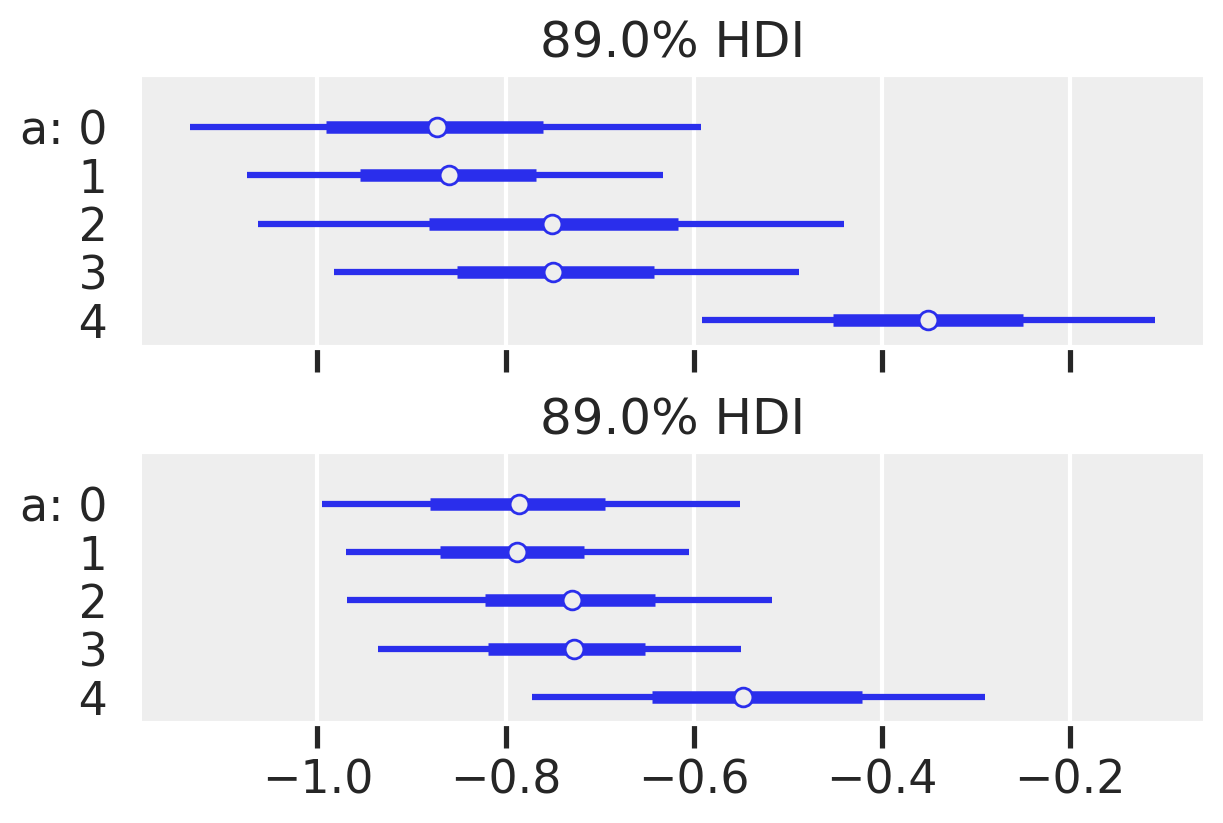

<IPython.core.display.Javascript object>

In [68]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
az.plot_forest(trace_m1, var_names=["a"], combined=True, ax=ax1)
az.plot_forest(trace_m2, var_names=["a"], combined=True, ax=ax2)

In [ ]:
# modified from repo
with pm.Model() as m_13_2:
    # adaptive prior
    a_bar = pm.Normal("a_bar", 0.0, 1.5)

    # prior for SD of tanks
    sigma = pm.Exponential("sigma", 1.0)

    # adaptive prior
    a = pm.Normal("a", a_bar, sigma, shape=n_tanks)

    p = pm.math.invlogit(a[tank])

    S = pm.Binomial("S", n=df_frogs["density"], p=p, observed=df_frogs["surv"])

    trace_13_2 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

# Coach only fixed effects model

**Model `m3` equation**

$$O_i \sim \text{Binomial}(n_i, p_i) \tag{O for number of on-base events}$$

$$\text{logit}(p_i) = \alpha_{\text{COACH}[i]} \tag{coach is encoded as an index variable}$$

$$\alpha_j \sim \text{Normal}(0, 2) \tag{regularizing prior for each pitcher}$$

In [20]:
df_padres.head()

,pitcher,game_date,n_ab,n_ob,obp,pitching_coach,pitcher_code,pitching_coach_code
0,"('weathers', 'ryan')",2021-07-01,20,9,0.450000,Rothschild,4,0
1,"('paddack', 'chris')",2021-07-02,26,5,0.192308,Rothschild,2,0
2,"('darvish', 'yu')",2021-07-03,25,7,0.280000,Rothschild,0,0
3,"('snell', 'blake')",2021-07-04,17,7,0.411765,Rothschild,3,0
4,"('musgrove', 'joe')",2021-07-05,24,8,0.333333,Rothschild,1,0


<IPython.core.display.Javascript object>

In [21]:
n_coach

2

<IPython.core.display.Javascript object>

In [22]:
# modified from repo
with pm.Model() as m3:
    # regularizing prior
    a = pm.Normal("a", 0.0, 2, shape=n_coach)
    # linear model
    p = pm.math.invlogit(a[df_padres["pitching_coach_code"]])
    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])
    # sample
    trace_m3 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


<IPython.core.display.Javascript object>

In [23]:
az.summary(trace_m3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.653,0.073,-0.763,-0.533,0.001,0.001,3671.0,3671.0,3661.0,2748.0,1.0
a[1],-1.433,0.259,-1.825,-0.987,0.004,0.003,3572.0,3418.0,3605.0,2603.0,1.0


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

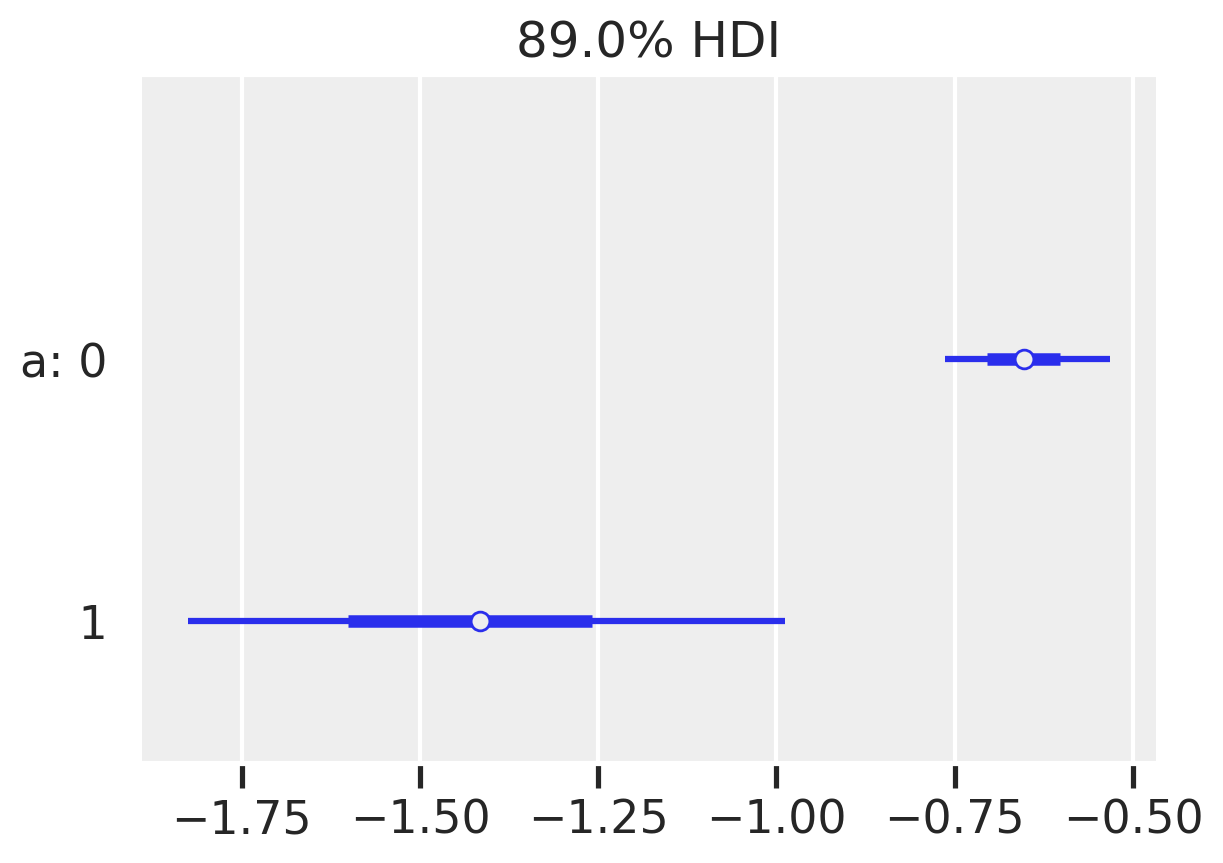

<IPython.core.display.Javascript object>

In [24]:
az.plot_forest(trace_m3, combined=True)

# Coach only mixed effects model
Let's look at a mixed effects with an intercept-only model of just coach.

**Model `m4` equation**

$$O_i \sim \text{Binomial}(n_i, p_i) \tag{O for number of on-base events}$$

$$\text{logit}(p_i) = \alpha_{\text{COACH}[i]} \tag{coach is encoded as an index variable}$$

$$\alpha_j \sim \text{Normal}(\bar{\alpha}, \sigma) \tag{adaptive prior}$$

$$\bar{\alpha} \sim \text{Normal}(0, 2) \tag{prior for average coach}$$

$$\sigma \sim \text{Exponential}(1) \tag{prior for SD of coaches}$$

In [25]:
df_padres.head()

,pitcher,game_date,n_ab,n_ob,obp,pitching_coach,pitcher_code,pitching_coach_code
0,"('weathers', 'ryan')",2021-07-01,20,9,0.450000,Rothschild,4,0
1,"('paddack', 'chris')",2021-07-02,26,5,0.192308,Rothschild,2,0
2,"('darvish', 'yu')",2021-07-03,25,7,0.280000,Rothschild,0,0
3,"('snell', 'blake')",2021-07-04,17,7,0.411765,Rothschild,3,0
4,"('musgrove', 'joe')",2021-07-05,24,8,0.333333,Rothschild,1,0


<IPython.core.display.Javascript object>

In [27]:
with pm.Model() as m4:

    # regularizing prior for average coach
    a_bar = pm.Normal("a_bar", 0, 2)

    # prior for SD of coachs
    sigma = pm.Exponential("sigma", 1)

    # addaptive prior learns across coachs
    a = pm.Normal("a", a_bar, sigma, shape=n_coach)

    # linear model
    p = pm.math.invlogit(a[df_padres["pitching_coach_code"]])

    # likelihood function
    O = pm.Binomial("O", n=df_padres["n_ab"], p=p, observed=df_padres["n_ob"])

    # sample
    trace_m4 = pm.sample(draws=1000, random_seed=19, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 148 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6351641315439731, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

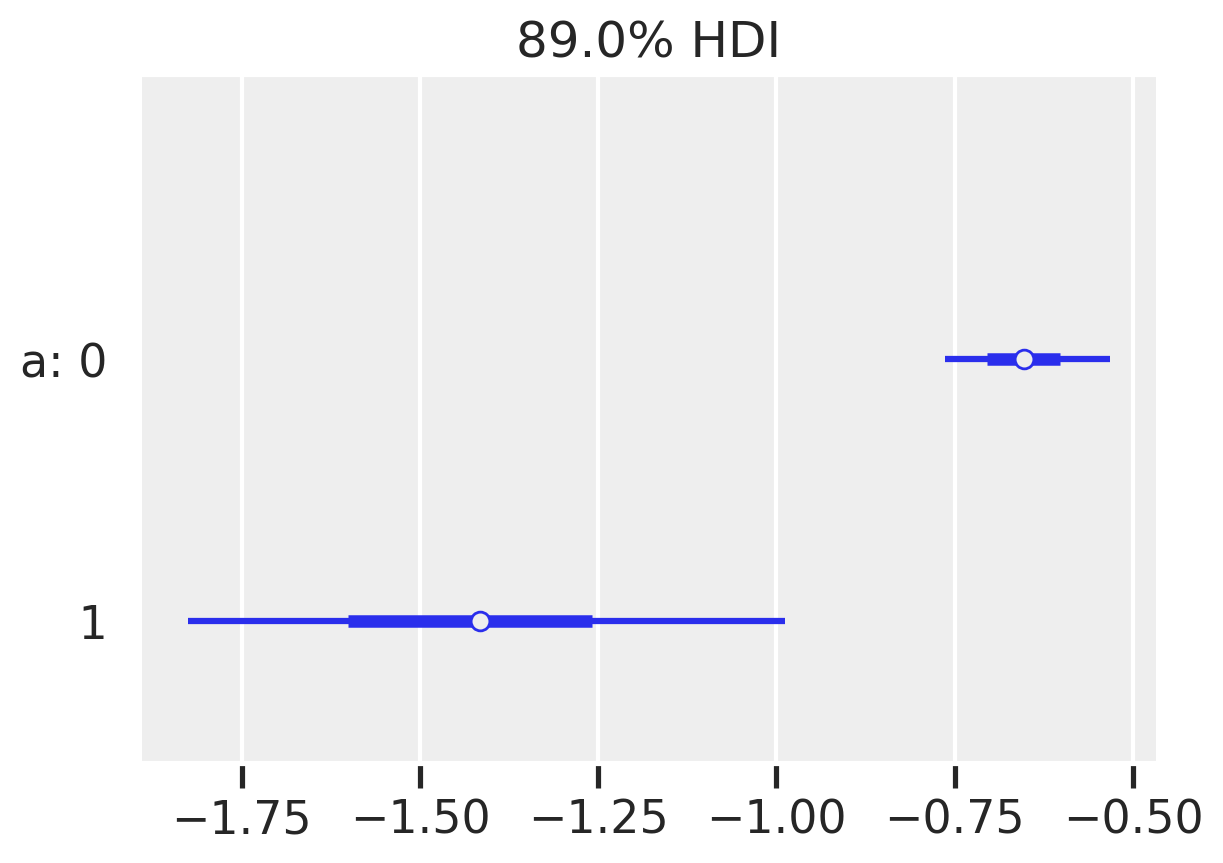

<IPython.core.display.Javascript object>

In [30]:
az.plot_forest(trace_m3, var_names=["a"], combined=True)

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

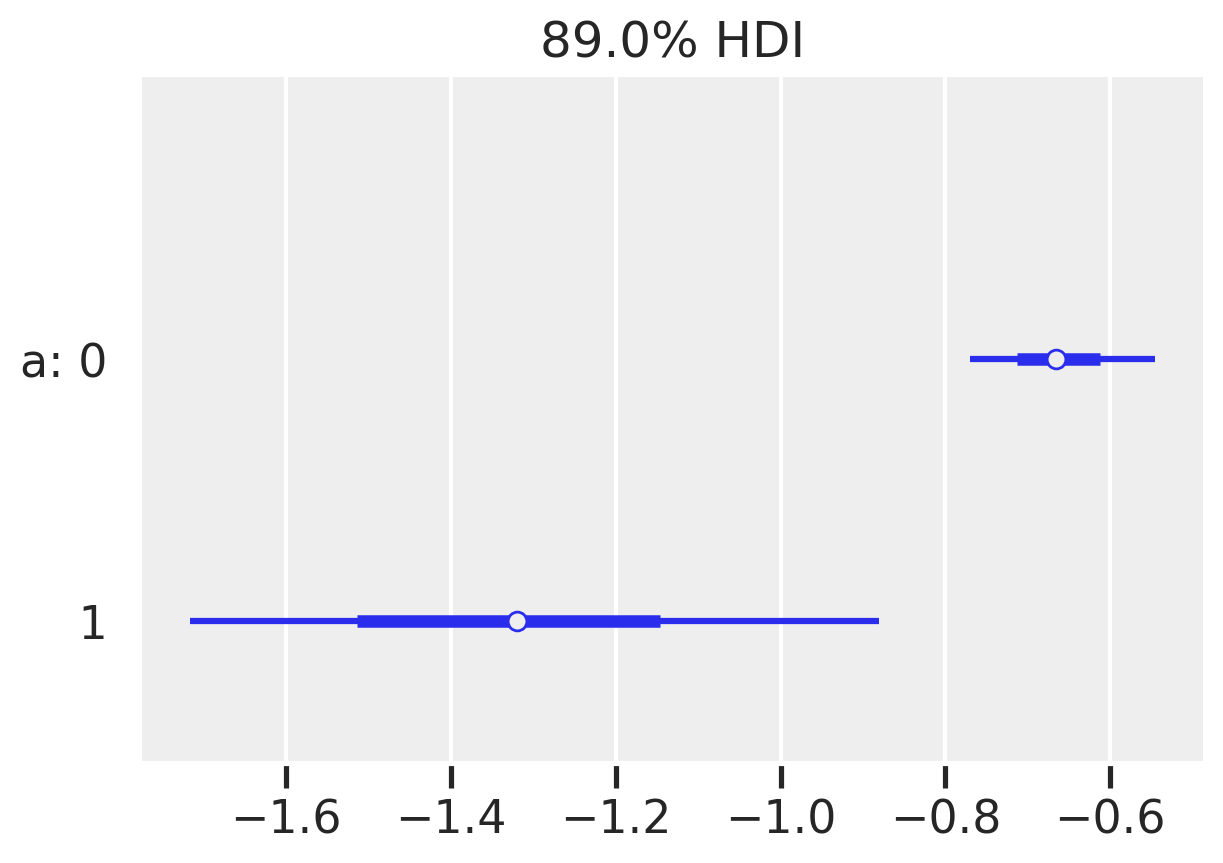

<IPython.core.display.Javascript object>

In [29]:
az.plot_forest(trace_m4, var_names=["a"], combined=True)

Appendix: Environment and system parameters

In [33]:
%watermark -n -u -v -iv -w

Last updated: Fri Jul 02 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pandas    : 1.2.1
matplotlib: 3.3.4
arviz     : 0.11.1
pymc3     : 3.11.0
daft      : 0.1.0
json      : 2.0.9
numpy     : 1.20.1
seaborn   : 0.11.1
scipy     : 1.6.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>